## Setting up

This data script is designed to run in another environment. It is not intended to be run in the Streamlit app.

Furthermore, the directory structure is not the same as the Streamlit app.

In [9]:
import os
import time
import json
import urllib.request
import pandas as pd
import random
import requests
import numpy as np

# Set API key
# api_key = userdata.get('CRYPTOCOMPARE_API_KEY')
# if not api_key:
#     raise ValueError("CRYPTOCOMPARE_API_KEY is not set. Please define it in environment variables.")

In [4]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [10]:
# Set seed for reproducibility
def set_seed(seed=42):
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    # tf.random.set_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

set_seed(42)

In [11]:
folder = os.getcwd()
data_path = os.path.join(folder, 'data')
os.makedirs(data_path, exist_ok=True)  
print(os.listdir(data_path))

['archive', 'crypto_data.csv', 'intermediate_datasets', 'post_norm_df.csv', 'pre_norm_df.csv', 'results']


## Crypto Price Data

In [ ]:
## Get symbols that are active on the top tier exchanges

# Define time thresholds
start_threshold = datetime(2022, 5, 12).timestamp()  # March 1, 2024
end_threshold = "2025-03-08"        # March 8, 2025

# Step 1: Fetch only active symbols (i.e., symbols with trading data)
exchanges_url = "https://min-api.cryptocompare.com/data/v4/all/exchanges"
exchanges_data = fetch_data_with_retries(exchanges_url)
exchanges_data = exchanges_data["Data"]["exchanges"]
print(f"Retrieved {len(exchanges_data)} active exchanges.")

# Function to fetch data with retries
def fetch_data_with_retries(url, retries=5):
    for i in range(retries):
        try:
            response = urllib.request.urlopen(url).read().decode("utf-8")
            return json.loads(response)
        except Exception as e:
            print(f"Attempt {i+1}: Failed to fetch data. Retrying in {2**i} seconds...")
            time.sleep(2**i + random.uniform(0, 1))  # Exponential backoff
    return None
    
# Extract active trading pairs from ONLY top-tier exchanges
active_symbols = set() # Set prevents duplicates
found_exchanges = []
for exchange, details in exchanges_data.items():
    if details.get("isTopTier", False) and details.get("isActive", False):  # Only use top-tier active exchanges
        found_exchanges.append(exchange)

        for base, pairs in details.get("pairs", {}).items():
            if "USDT" in pairs.get("tsyms", {}):  # Only check USDT pairs
                usdt_pair = pairs["tsyms"]["USDT"]
                histo_start = usdt_pair.get("histo_minute_start_ts", 0)  # Start timestamp
                histo_end = usdt_pair.get("histo_minute_end", 0)      # End timestamp

                if histo_start < start_threshold and histo_end == end_threshold:
                    active_symbols.add(base)  # Add base symbol if it meets criteria

valid_symbols_list = list(active_symbols)
print(f"✅ Found and processed {len(found_exchanges)} top-tier exchanges: {found_exchanges}")
print(f"✅ Retrieved {len(valid_symbols_list)} active cryptocurrencies from top-tier exchanges.")

In [ ]:
## Get symbols ranked by market cap

import requests
# Set API key and limit
api_key = 'YOUR_API_KEY'
limit = 100  # Max allowed limit per request
page = 0     # Start with the first page
ranked_symbols = []

while True:
    # Request top market cap coins
    mktcap_url = f"https://min-api.cryptocompare.com/data/top/mktcapfull?tsym=USD&limit={limit}&page={page}&api_key={api_key}"
    response = requests.get(mktcap_url).json()

    if 'Data' in response and response['Data']:
        # Extract coin symbols
        ranked_symbols.extend([coin["CoinInfo"]["Name"] for coin in response["Data"]])
        page += 1  # Move to the next page
    else:
        break  # Exit loop when no more data

print(f"✅ Extracted {len(ranked_symbols)} ranked symbols.")
print("Top 10 Ranked Symbols:", ranked_symbols[:10])

In [ ]:
## Get Symbols that are both active and in the top ~1200 ranked by market cap

valid_symbols_list = [sym for sym in ranked_symbols if sym in active_symbols]

print(f"Filtered down to {len(valid_symbols_list)} top-ranked active cryptocurrencies.")

In [ ]:
## Get data for identified symbols

# Storing data
data_list = []
valid_symbols = []
error_names = []
no_error = 0

# Step 3: Fetch historical data for valid symbols (single API call per symbol)
for symbol in valid_symbols_list:
    url = f"https://min-api.cryptocompare.com/data/v2/histoday?fsym={symbol}&tsym=USD&limit=1030&api_key={api_key}"

    price_data = fetch_data_with_retries(url)
    if price_data is None or price_data.get("Response") == "Error":
        no_error += 1
        error_names.append(symbol)
        print(f"❌ Error fetching data for {symbol}")
        continue

    # Convert API JSON response to DataFrame (Fetch all features: open, high, low, close, volumefrom, volumeto)
    price_df = pd.DataFrame(price_data["Data"]["Data"]).infer_objects()
    price_df["symbol"] = symbol  # Add symbol column

    # Ensure it has at least 1030 time periods
    if len(price_df) >= 1030:
        valid_symbols.append(symbol)  # Store valid symbol

        # Reshape data from wide to long format
        price_long = price_df.melt(id_vars=["time", "symbol"], var_name="metric", value_name="value")

        # Append to list (instead of merging DataFrames)
        data_list.append(price_long)

        print(f"✔ {symbol} added with {len(price_df)} time periods ✅")
    else:
        print(f"❌ Skipping {symbol} since it has only {len(price_df)} time periods ❌")

    # Prevent rate-limiting issues
    time.sleep(1)

# Step 4: Convert to DataFrame and save
long_format_df = pd.concat(data_list, ignore_index=True)

# Convert UNIX timestamps to standard time
long_format_df["standard_time"] = pd.to_datetime(long_format_df["time"], unit="s")

# Save valid symbols and data
valid_symbols_path = os.path.join(folder, 'valid_symbols_1000.csv')
pd.DataFrame(valid_symbols, columns=["Symbol"]).to_csv(valid_symbols_path, index=False)
data_path = os.path.join(folder, 'crypto_prices_long_1000.csv')
long_format_df.to_csv(data_path, index=False)

wide_format_df = long_format_df.pivot(index=["time", "symbol", "standard_time"],
                                      columns="metric",
                                      values="value").reset_index()
wide_format_df.columns.name = None
symbol_rank = {symbol: rank for rank, symbol in enumerate(ranked_symbols)}
wide_format_df["symbol_rank"] = wide_format_df["symbol"].map(symbol_rank)
wide_format_df = wide_format_df.sort_values(by=["symbol_rank", "time"]).drop(columns=['symbol_rank', 'conversionSymbol', 'conversionType']).reset_index(drop=True)
wide_format_df.head()
crypto_prices_wide_1000_path = os.path.join(folder, 'crypto_prices_wide_1000.csv')
wide_format_df.to_csv(crypto_prices_wide_1000_path, index=False)

## Crypto Sentiment Data

### Based on coin description

In [ ]:
## Get metadata from different endpoint

url = "https://min-api.cryptocompare.com/data/all/coinlist"
all_crypto = urllib.request.urlopen(url).read().decode('utf8')
all_crypto = json.loads(all_crypto)
all_crypto = pd.DataFrame(all_crypto['Data']).T

all_crypto = all_crypto.astype({"Id" : int, "ContentCreatedOn" : int, "SortOrder" : int})
all_crypto = all_crypto.sort_values("SortOrder")
all_crypto.head()

In [ ]:
## Check if identified symbols are valid

filtered_crypto = all_crypto[all_crypto['Symbol'].isin(valid_symbols_list)].copy()
print(filtered_crypto.shape)

In [ ]:
## Change columns from stacked to multiple columns

# 'taxonomy' column from JSON like structure into independent columns

import ast

filtered_crypto['Taxonomy'] = filtered_crypto['Taxonomy'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract relevant fields into separate columns
taxonomy_keys = ['Access', 'FCA', 'Industry','CollateralizedAssetType']

for key in taxonomy_keys:
    filtered_crypto[key] = filtered_crypto['Taxonomy'].apply(lambda x: x.get(key, '') if isinstance(x, dict) else '')

# Drop the original 'Taxonomy' column since it's now expanded
filtered_crypto.drop(columns=['Taxonomy'], inplace=True)

# Change 'PlatformType' column into own columns

filtered_crypto['IsToken'] = (filtered_crypto['PlatformType'] == 'token').astype(int)
filtered_crypto['IsCoin'] = (filtered_crypto['PlatformType'] == 'blockchain').astype(int)

# Drop the original 'PlatformType' column
filtered_crypto.drop(columns=['PlatformType'], inplace=True)

In [ ]:
## Drop unnecessary columns

columns_to_drop = ['Id', 'Url', 'ImageUrl', 'ContentCreatedOn', 'Name','AssetTokenStatus', 'Algorithm',
       'ProofType', 'SortOrder', 'Sponsored','Rating',
       'IsTrading', 'TotalCoinsMined', 'CirculatingSupply', 'BlockNumber',
       'NetHashesPerSecond', 'BlockReward', 'BlockTime', 'AssetLaunchDate',
       'AssetWhitepaperUrl', 'AssetWebsiteUrl', 'MaxSupply','MktCapPenalty',
       'SmartContractAddress', 'OtherSmartContractAddress', 'DecimalPoints',
       'Difficulty', 'AlgorithmType', 'CollateralizedAssetType', 'BuiltOn', 'Access', 'FCA', 'Industry']

filtered_crypto.drop(columns=columns_to_drop, inplace=True)
filtered_crypto = filtered_crypto[filtered_crypto['Symbol'] != 'OKB'] # OKB has 100 market cap penalty suggesting concerns regarding liquidity

print(filtered_crypto.shape)
filtered_crypto.head(2)

In [5]:
## Get Coin/Token sentiment based on their writeup

from transformers import pipeline
# Get sentiment based on Description and assign score from 0 to 1
# Model: DistilBERT fine-tuned on SST-2 using HuggingFace
# Popular Coins with strong narrative like BTC should be given 1
# If the Description is written very positively, should also be given higher

# Load a sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Function to compute usefulness score based on sentiment confidence
def compute_usefulness(description):
    if pd.isna(description) or not isinstance(description, str) or description.strip() == "":
        return 0  # Assign 0 if description is missing or empty

    # Run sentiment analysis
    result = sentiment_pipeline(description[:512])  # Truncate to 512 tokens for efficiency
    score = result[0]['score']  # Extract confidence score

    return round(score, 2)  # Round to 2 decimal places



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Device set to use cpu


In [ ]:
# Apply usefulness scoring to the Description column
filtered_crypto['coin_sentiment'] = filtered_crypto['Description'].apply(compute_usefulness)

# Display the first few rows
print(filtered_crypto[['Symbol', 'Description', 'Sentiment']].head())

# Drop the Description column bcs it has no use now
filtered_crypto.drop(columns=['Description'], inplace=True)

### Based on Reddit

In [3]:
import praw

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from pydantic import BaseModel, Field, ValidationError
from typing import Literal

In [4]:
import logging
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
for logger_name in ("praw", "prawcore"):
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.DEBUG)
    logger.addHandler(handler)

In [9]:
client_id = os.getenv("REDDIT_CLIENT_ID")
client_secret = os.getenv("REDDIT_CLIENT_SECRET")

In [10]:
reddit = praw.Reddit(
client_id =client_id,
client_secret = client_secret,
user_agent='Windows:reddit_bitcoin_scraper:v1 (by /u/Critical_Product_103)',
)

In [11]:
subreddits_of_interest = ["CryptoCurrency", "Bitcoin", "btc", "CryptoMarkets", "ethereum", "litecoin", "dogecoin", "XRP"]
subreddits = reddit.subreddit("+".join(subreddits_of_interest))

In [ ]:
start_date = '2022-06-01'
start_date = pd.to_datetime(start_date).tz_localize('UTC')

posts_by_date = defaultdict(list)

for post in subreddits.top(time_filter= "year", limit=None):
    post_date = pd.to_datetime(post.created_utc, unit='s', utc=True)

    if post_date > start_date:
        # Collect the details of the post without comments
        post_data = {
            "post_id": post.id,  # Post ID
            "title": post.title,
            "body": post.selftext if post.selftext else "No text body (link post)",
            "author": post.author.name if post.author else "Unknown",  # Post author
            "upvotes": post.ups,  # Number of upvotes
            "downvotes": post.downs,  # Number of downvotes
            "score": post.score,  # Post score (upvotes - downvotes)
            "num_comments": post.num_comments,  # Number of comments
            "url": post.url,  # URL of the post
            "created_at": post_date,  # Post creation date
            "subreddit": post.subreddit.display_name,  # Subreddit name
        }

        # Append to the respective date key
        posts_by_date[post_date].append(post_data)
    
    else:
        continue

# df = pd.DataFrame([p for posts in posts_by_date.values() for p in posts])


Fetching: GET https://oauth.reddit.com/r/CryptoCurrency+Bitcoin+btc+CryptoMarkets+ethereum+litecoin+dogecoin+XRP/top at 1742298792.4849036
Data: None
Params: {'limit': 1024, 'raw_json': 1, 't': 'year'}
Response: 200 (74505 bytes) (rst-407:rem-999.0:used-1 ratelimit) at 1742298794.9169748
Fetching: GET https://oauth.reddit.com/r/CryptoCurrency+Bitcoin+btc+CryptoMarkets+ethereum+litecoin+dogecoin+XRP/top at 1742298794.9660077
Data: None
Params: {'after': 't3_1i5e6pi', 'limit': 1024, 'raw_json': 1, 't': 'year'}
Response: 200 (70304 bytes) (rst-405:rem-998.0:used-2 ratelimit) at 1742298796.9664845
Fetching: GET https://oauth.reddit.com/r/CryptoCurrency+Bitcoin+btc+CryptoMarkets+ethereum+litecoin+dogecoin+XRP/top at 1742298797.0067859
Data: None
Params: {'after': 't3_1i9onno', 'limit': 1024, 'raw_json': 1, 't': 'year'}
Response: 200 (67552 bytes) (rst-403:rem-997.0:used-3 ratelimit) at 1742298799.0200799
Fetching: GET https://oauth.reddit.com/r/CryptoCurrency+Bitcoin+btc+CryptoMarkets+ether

In [ ]:
# df['date_created'] = df['created_at'].dt.date
# df_sorted = df.sort_values(by=['date_created','created_at']).reset_index(drop=True)

In [15]:
def get_top_comments(post_id, limit=100):
    """
    Function to fetch the top comments for a given Reddit post by post_id.
    """
    try:
        # Fetch the submission (post) using its ID
        submission = reddit.submission(id=post_id)
        
        # Get top comments (replace 'limit' with 200 to get the top 200 comments)
        submission.comments.replace_more(limit=0)  # Avoid "MoreComments" object
        top_comments = submission.comments.list()
        
        # Limit to the top 100 comments
        top_comments = top_comments[:limit]
        
        return [comment.body for comment in top_comments]  # Return the comment bodies
    
    except Exception as e:
        print(f"Error fetching comments for post {post_id}: {e}")
        return []

# Example to add top comments to your DataFrame
def run_func(df):
    top_comments_list = []
    for post_id in df['post_id']:
        if post_id:
            comments = get_top_comments(post_id)
        else:
            comments = []
        top_comments_list.append(comments)
    return top_comments_list

In [ ]:
# top_comments_list = run_func(df_sorted)
# df_sorted['top_comments'] = top_comments_list

Fetching: GET https://oauth.reddit.com/comments/1bhp7xo/ at 1742298973.8675377
Data: None
Params: {'limit': 2048, 'raw_json': 1, 'sort': 'confidence'}
Response: 200 (1876 bytes) (rst-226:rem-930.0:used-70 ratelimit) at 1742298974.308404
Fetching: GET https://oauth.reddit.com/comments/1bhqsaa/ at 1742298974.3103945
Data: None
Params: {'limit': 2048, 'raw_json': 1, 'sort': 'confidence'}
Response: 200 (3964 bytes) (rst-226:rem-929.0:used-71 ratelimit) at 1742298974.7219992
Fetching: GET https://oauth.reddit.com/comments/1bhsisr/ at 1742298974.7242007
Data: None
Params: {'limit': 2048, 'raw_json': 1, 'sort': 'confidence'}
Response: 200 (109360 bytes) (rst-225:rem-928.0:used-72 ratelimit) at 1742298977.9217424
Fetching: GET https://oauth.reddit.com/comments/1bhu4c1/ at 1742298977.9816206
Data: None
Params: {'limit': 2048, 'raw_json': 1, 'sort': 'confidence'}
Response: 200 (9064 bytes) (rst-222:rem-927.0:used-73 ratelimit) at 1742298978.7725942
Fetching: GET https://oauth.reddit.com/comments

In [18]:
df_sorted

post_id                                              title  \
0     1bhp7xo  "Congrats @GeneralProtocol for the AnyHedge TV...   
1     1bhqsaa                        Staking ETH on Ledger live.   
2     1bhsisr  Realised today that I don't like where Ethereu...   
3     1bhu4c1  "Strongly agree. My suggestion 2MB now, then 4...   
4     1bhu9ag  r/cc users are realizing that BTC & ETH do not...   
...       ...                                                ...   
6844  1ia4djz                        This is what I like to see.   
6845  1ia5qv9                                   Crypto and Trump   
6846  1ia6dmp     Bitcoin modders are scared of an honest debate   
6847  1ia7rqo                      LTC to $2,475 in 2025 or ban.   
6848  1ia88j8        Daily General Discussion - January 26, 2025   

                                                   body               author  \
0                              No text body (link post)             Mr-Zwets   
1     He guys i have a question... Is it 100% safe t...      Workbrowsing247   
2     Background :\n\nI only hold BTC and ETH (70%/3...             ENTIMEYJ   
3     Adam recently wrote this:\n\n[https://www.redd...           estebansaa   
4                              No text body (link post)         rareinvoices   
...                                                 ...                  ...   
6844  One more day on the chart until an expected br...          8billionto1   
6845  So... why is everybody so sure that this new T...    Rock-bottom-no-no   
6846                           No text body (link post)          CoolSheprad   
6847                           No text body (link post)  MaximumUpstairs2333   
6848  **Welcome to the Ethereum Daily General Discus...  EthereumDailyThread   

      upvotes  downvotes  score  num_comments  \
0          32          0     32             1   
1          11          0     11            12   
2         751          0    751           863   
3          39          0     39            48   
4          39          0     39            21   
...       ...        ...    ...           ...   
6844      974          0    974           201   
6845      296          0    296           181   
6846      243          0    243            83   
6847      166          0    166            66   
6848      202          0    202           291   

                                                    url  \
0     https://x.com/GeukensMathieu/status/1769697476...   
1     https://www.reddit.com/r/ethereum/comments/1bh...   
2     https://www.reddit.com/r/CryptoCurrency/commen...   
3     https://www.reddit.com/r/btc/comments/1bhu4c1/...   
4     https://np.reddit.com/r/CryptoCurrency/comment...   
...                                                 ...   
6844             https://www.reddit.com/gallery/1ia4djz   
6845  https://www.reddit.com/r/CryptoMarkets/comment...   
6846             https://www.reddit.com/gallery/1ia6dmp   
6847                https://i.redd.it/epi846zt7afe1.png   
6848  https://www.reddit.com/r/ethereum/comments/1ia...   

                    created_at       subreddit date_created  \
0    2024-03-18 12:12:27+00:00             btc   2024-03-18   
1    2024-03-18 13:31:08+00:00        ethereum   2024-03-18   
2    2024-03-18 14:48:01+00:00  CryptoCurrency   2024-03-18   
3    2024-03-18 15:55:03+00:00             btc   2024-03-18   
4    2024-03-18 16:00:34+00:00             btc   2024-03-18   
...                        ...             ...          ...   
6844 2025-01-26 03:03:34+00:00             XRP   2025-01-26   
6845 2025-01-26 04:21:35+00:00   CryptoMarkets   2025-01-26   
6846 2025-01-26 04:59:35+00:00             XRP   2025-01-26   
6847 2025-01-26 06:28:15+00:00        litecoin   2025-01-26   
6848 2025-01-26 07:01:18+00:00        ethereum   2025-01-26   

                                           top_comments  
0                                                    []  
1     [WARNING ABOUT SCAMS: Recently there have been...  

In [ ]:
# df_sorted.to_csv(os.path.join(data_path,'reddit_top_comments_data.csv'))

### Importing saved data

In [10]:
reddit_top_comments_path = os.path.join("data", "reddit_top_comments_data.csv")
df_sorted = pd.read_csv(reddit_top_comments_path).drop(columns=['Unnamed: 0'], errors='ignore')
df_sorted

post_id                                              title  \
0     1bhp7xo  "Congrats @GeneralProtocol for the AnyHedge TV...   
1     1bhqsaa                        Staking ETH on Ledger live.   
2     1bhsisr  Realised today that I don't like where Ethereu...   
3     1bhu4c1  "Strongly agree. My suggestion 2MB now, then 4...   
4     1bhu9ag  r/cc users are realizing that BTC & ETH do not...   
...       ...                                                ...   
6844  1ia4djz                        This is what I like to see.   
6845  1ia5qv9                                   Crypto and Trump   
6846  1ia6dmp     Bitcoin modders are scared of an honest debate   
6847  1ia7rqo                      LTC to $2,475 in 2025 or ban.   
6848  1ia88j8        Daily General Discussion - January 26, 2025   

                                                   body               author  \
0                              No text body (link post)             Mr-Zwets   
1     He guys i have a question... Is it 100% safe t...      Workbrowsing247   
2     Background :\n\nI only hold BTC and ETH (70%/3...             ENTIMEYJ   
3     Adam recently wrote this:\n\n[https://www.redd...           estebansaa   
4                              No text body (link post)         rareinvoices   
...                                                 ...                  ...   
6844  One more day on the chart until an expected br...          8billionto1   
6845  So... why is everybody so sure that this new T...    Rock-bottom-no-no   
6846                           No text body (link post)          CoolSheprad   
6847                           No text body (link post)  MaximumUpstairs2333   
6848  **Welcome to the Ethereum Daily General Discus...  EthereumDailyThread   

      upvotes  downvotes  score  num_comments  \
0          32          0     32             1   
1          11          0     11            12   
2         751          0    751           863   
3          39          0     39            48   
4          39          0     39            21   
...       ...        ...    ...           ...   
6844      974          0    974           201   
6845      296          0    296           181   
6846      243          0    243            83   
6847      166          0    166            66   
6848      202          0    202           291   

                                                    url  \
0     https://x.com/GeukensMathieu/status/1769697476...   
1     https://www.reddit.com/r/ethereum/comments/1bh...   
2     https://www.reddit.com/r/CryptoCurrency/commen...   
3     https://www.reddit.com/r/btc/comments/1bhu4c1/...   
4     https://np.reddit.com/r/CryptoCurrency/comment...   
...                                                 ...   
6844             https://www.reddit.com/gallery/1ia4djz   
6845  https://www.reddit.com/r/CryptoMarkets/comment...   
6846             https://www.reddit.com/gallery/1ia6dmp   
6847                https://i.redd.it/epi846zt7afe1.png   
6848  https://www.reddit.com/r/ethereum/comments/1ia...   

                     created_at       subreddit date_created  \
0     2024-03-18 12:12:27+00:00             btc   2024-03-18   
1     2024-03-18 13:31:08+00:00        ethereum   2024-03-18   
2     2024-03-18 14:48:01+00:00  CryptoCurrency   2024-03-18   
3     2024-03-18 15:55:03+00:00             btc   2024-03-18   
4     2024-03-18 16:00:34+00:00             btc   2024-03-18   
...                         ...             ...          ...   
6844  2025-01-26 03:03:34+00:00             XRP   2025-01-26   
6845  2025-01-26 04:21:35+00:00   CryptoMarkets   2025-01-26   
6846  2025-01-26 04:59:35+00:00             XRP   2025-01-26   
6847  2025-01-26 06:28:15+00:00        litecoin   2025-01-26   
6848  2025-01-26 07:01:18+00:00        ethereum   2025-01-26   

                                           top_comments  
0                                                    []  
1     ['WARNING ABOUT SCAMS: Recently there h

In [11]:
## Get sentiment based on Reddit posts and comments

from transformers import pipeline

# Get sentiment based on Description and assign score from 0 to 1
# Model: DistilBERT fine-tuned on SST-2 using HuggingFace
# Popular Coins with strong narrative like BTC should be given 1
# If the Description is written very positively, should also be given higher

# Load a sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Function to compute usefulness score based on sentiment confidence
def get_sentiment(post_title, post_body, comments):
    # Combine post title, body and comments
    description = post_title + ' ' + post_body + ''.join(comments)
    if pd.isna(description) or not isinstance(description, str) or description.strip() == "":
        return 0  # Assign 0 if description is missing or empty

    # Run sentiment analysis
    result = sentiment_pipeline(description[:512])  # Limit to 512 characters for DistilBERT
    score = result[0]['score']  # Extract confidence score

    return round(score, 2)  # Round to 2 decimal places

# Apply the function to the DataFrame
df_sorted["reddit_sentiment"] = df_sorted.apply(lambda row: get_sentiment(row["title"], row["body"], row["top_comments"]), axis=1)

# Display the first few rows
print(df_sorted[['title', "reddit_sentiment"]].head())

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


                                               title  reddit_sentiment
0  "Congrats @GeneralProtocol for the AnyHedge TV...              1.00
1                        Staking ETH on Ledger live.              1.00
2  Realised today that I don't like where Ethereu...              1.00
3  "Strongly agree. My suggestion 2MB now, then 4...              0.98
4  r/cc users are realizing that BTC & ETH do not...              0.99


In [ ]:
# Model: joeddav/distilbert-base-uncased-go-emotions-student
# Outputs a list with a dictionary with a label and score for each label
#[
#     {'label': 'anger', 'score': 0.75},
#     {'label': 'sadness', 'score': 0.20}
# ]

# Load the emotion classification model
emotion_pipeline = pipeline("text-classification", model="joeddav/distilbert-base-uncased-go-emotions-student")

# Function to compute usefulness score based on emotion confidence
def get_emotion(post_title, post_body, comments):
    # Initialize empty DataFrame
    emotions_dict = {}
    # Combine post title, body and comments
    description = post_title +'' + post_body + ''.join(comments)

    if pd.isna(description) or not isinstance(description, str) or description.strip() == "":
        return emotions_dict  # Assign empty list if description is missing or empty

    # Run emotion analysis
    result = emotion_pipeline(description[:512])
    for emotion in result:
        emotions_dict[emotion['label']] = round(emotion['score'], 2)  # Store detected emotions
    return emotions_dict

# Apply the function and expand the dictionary into separate columns
emotion_df = df_sorted.apply(lambda row: get_emotion(row["title"], row["body"], row["top_comments"]), axis=1, result_type="expand")

# Rename columns to match your naming convention (e.g., reddit_joy, reddit_anger)
emotion_df = emotion_df.rename(columns=lambda col: f"reddit_{col}")

# Merge with the original dataframe
df_sorted = pd.concat([df_sorted, emotion_df], axis=1)

# Display the first few rows
df_sorted.head()

Device set to use cpu


post_id                                              title  \
0  1bhp7xo  "Congrats @GeneralProtocol for the AnyHedge TV...   
1  1bhqsaa                        Staking ETH on Ledger live.   
2  1bhsisr  Realised today that I don't like where Ethereu...   
3  1bhu4c1  "Strongly agree. My suggestion 2MB now, then 4...   
4  1bhu9ag  r/cc users are realizing that BTC & ETH do not...   

                                                body           author  \
0                           No text body (link post)         Mr-Zwets   
1  He guys i have a question... Is it 100% safe t...  Workbrowsing247   
2  Background :\n\nI only hold BTC and ETH (70%/3...         ENTIMEYJ   
3  Adam recently wrote this:\n\n[https://www.redd...       estebansaa   
4                           No text body (link post)     rareinvoices   

   upvotes  downvotes  score  num_comments  \
0       32          0     32             1   
1       11          0     11            12   
2      751          0    751           863   
3       39          0     39            48   
4       39          0     39            21   

                                                 url  \
0  https://x.com/GeukensMathieu/status/1769697476...   
1  https://www.reddit.com/r/ethereum/comments/1bh...   
2  https://www.reddit.com/r/CryptoCurrency/commen...   
3  https://www.reddit.com/r/btc/comments/1bhu4c1/...   
4  https://np.reddit.com/r/CryptoCurrency/comment...   

                  created_at  ... reddit_admiration reddit_disapproval  \
0  2024-03-18 12:12:27+00:00  ...               NaN                NaN   
1  2024-03-18 13:31:08+00:00  ...               NaN                NaN   
2  2024-03-18 14:48:01+00:00  ...               NaN                NaN   
3  2024-03-18 15:55:03+00:00  ...               NaN                NaN   
4  2024-03-18 16:00:34+00:00  ...               NaN                NaN   

  reddit_remorse  reddit_nervousness  reddit_embarrassment  reddit_relief  \
0            NaN                 NaN                   NaN            NaN   
1            NaN                 NaN                   NaN            NaN   
2            NaN                 NaN                   NaN            NaN   
3            NaN                 NaN                   NaN            NaN   
4            NaN                 NaN                   NaN            NaN   

   reddit_grief  reddit_pride  reddit_love  reddit_neutral  
0           NaN           NaN          NaN             NaN  
1           NaN           NaN          NaN             NaN  
2           NaN           NaN          NaN             NaN  
3           NaN           NaN          NaN             NaN  
4           NaN           NaN          NaN             NaN  

[5 rows x 42 columns]

In [ ]:
df_sorted = df_sorted.fillna(0)

# df_sorted.to_csv(os.path.join(data_path,'reddit_data.csv'))

## Alternative data (Macro, Fear and Greed Index, Gas, Gold, News)

In [105]:
## Fred Data

import pandas as pd
import pandas_datareader.data as web
import datetime

# List of economic indicators
macro_indicators = ["DTWEXBGS", "VIXCLS", "DGS10", "UMCSENT","RSAFS"]

# Define date range
start = datetime.datetime(2022, 1, 1)
end = datetime.datetime.today()

# Fetch data from FRED
macro_data = web.DataReader(macro_indicators, "fred", start, end)

# Rename columns
macro_data = macro_data.rename(columns={"DTWEXBGS": "USD_strength_index", "VIXCLS": "CBOE_volatility_index", "DGS10": "treasury_yield_10yr", "UMCSENT": "consumer_sentiment_index", "RSAFS": "retail_sales"}).reset_index()

In [106]:
macro_data.head()

DATE  USD_strength_index  CBOE_volatility_index  treasury_yield_10yr  \
0 2022-01-01                 NaN                    NaN                  NaN   
1 2022-01-03            115.4243                  16.60                 1.63   
2 2022-01-04            115.3263                  16.91                 1.66   
3 2022-01-05            115.1524                  19.73                 1.71   
4 2022-01-06            115.4189                  19.61                 1.73   

   consumer_sentiment_index  retail_sales  
0                      67.2      644034.0  
1                       NaN           NaN  
2                       NaN           NaN  
3                       NaN           NaN  
4                       NaN           NaN

In [107]:
CPI_path = os.path.join("data", "CPI.csv")
CPI_data = pd.read_csv(CPI_path).rename(columns={"observation_date": "DATE", "CPIAUCSL": "CPI"})
CPI_data["DATE"] = pd.to_datetime(CPI_data["DATE"])
CPI_data['CPI'] = CPI_data['CPI'].astype(float)

FEDFUNDS_path = os.path.join("data", "FEDFUNDS.csv")
FEDFUNDS_data = pd.read_csv(FEDFUNDS_path).rename(columns={"observation_date": "DATE"})
FEDFUNDS_data["DATE"] = pd.to_datetime(FEDFUNDS_data["DATE"])
FEDFUNDS_data['FEDFUNDS'] = FEDFUNDS_data['FEDFUNDS'].astype(float)

UNRATE_path = os.path.join("data", "UNRATE.csv")
UNRATE_data = pd.read_csv(UNRATE_path).rename(columns={"observation_date": "DATE"})
UNRATE_data["DATE"] = pd.to_datetime(UNRATE_data["DATE"])
UNRATE_data['UNRATE'] = UNRATE_data['UNRATE'].astype(float)

macro_data = macro_data.merge(CPI_data, on='DATE', how="outer")
macro_data = macro_data.merge(FEDFUNDS_data, on='DATE', how="outer")
macro_data = macro_data.merge(UNRATE_data, on='DATE', how="outer")

macro_data

DATE  USD_strength_index  CBOE_volatility_index  \
0    1947-01-01                 NaN                    NaN   
1    1947-02-01                 NaN                    NaN   
2    1947-03-01                 NaN                    NaN   
3    1947-04-01                 NaN                    NaN   
4    1947-05-01                 NaN                    NaN   
...         ...                 ...                    ...   
1742 2025-03-11            126.2896                  26.92   
1743 2025-03-12            126.1251                  24.23   
1744 2025-03-13            126.2551                  24.66   
1745 2025-03-14            125.9538                  21.77   
1746 2025-03-17                 NaN                  20.51   

      treasury_yield_10yr  consumer_sentiment_index  retail_sales    CPI  \
0                     NaN                       NaN           NaN  21.48   
1                     NaN                       NaN           NaN  21.62   
2                     NaN                       NaN           NaN  22.00   
3                     NaN                       NaN           NaN  22.00   
4                     NaN                       NaN           NaN  21.95   
...                   ...                       ...           ...    ...   
1742                 4.28                       NaN           NaN    NaN   
1743                 4.32                       NaN           NaN    NaN   
1744                 4.27                       NaN           NaN    NaN   
1745                 4.31                       NaN           NaN    NaN   
1746                 4.31                       NaN           NaN    NaN   

      FEDFUNDS  UNRATE  
0          NaN     NaN  
1          NaN     NaN  
2          NaN     NaN  
3          NaN     NaN  
4          NaN     NaN  
...        ...     ...  
1742       NaN     NaN  
1743       NaN     NaN  
1744       NaN     NaN  
1745       NaN     NaN  
1746       NaN     NaN  

[1747 rows x 9 columns]

In [ ]:
from prognosis.widget import get_widget_data


country_code = 'US'
widget_name = 'supermarket-country-index'
options = {'country': country_code}

# Fetch the data
grocery_data = get_widget_data(widget_name, options)


grocery_data = pd.DataFrame(grocery_data)
# Rename columns
grocery_data = grocery_data.rename(columns={"dt": "DATE", "Real time index": "grocery_prices_index"}).reset_index()
grocery_data["DATE"] = pd.to_datetime(grocery_data["DATE"])
# Drop columns
grocery_data = grocery_data.drop(columns=["increased", "decreased", "index"])

grocery_data


DATE  grocery_prices_index     CPIUS
0  2021-06-01                   NaN  0.870151
1  2021-07-01                   NaN  0.874427
2  2021-08-01              0.835938  0.876983
3  2021-09-01              0.830820  0.880513
4  2021-10-01              0.837147  0.888701
5  2021-11-01              0.844593  0.896304
6  2021-12-01              0.852468  0.902763
7  2022-01-01              0.868668  0.907849
8  2022-02-01              0.883519  0.914745
9  2022-03-01              0.899111  0.924447
10 2022-04-01              0.915944  0.928340
11 2022-05-01              0.935119  0.936683
12 2022-06-01              0.972246  0.948376
13 2022-07-01              0.986332  0.948314
14 2022-08-01              0.997783  0.949060
15 2022-09-01              1.006233  0.952700
16 2022-10-01              1.011663  0.957593
17 2022-11-01              1.012795  0.960116
18 2022-12-01              1.011353  0.960644
19 2023-01-01              1.013217  0.965607
20 2023-02-01              1.007582  0.969314
21 2023-03-01              1.008612  0.970070
22 2023-04-01              1.004655  0.974210
23 2023-05-01              0.999777  0.975281
24 2023-06-01              1.000069  0.977332
25 2023-07-01              1.002285  0.979341
26 2023-08-01              1.001825  0.984353
27 2023-09-01              1.000097  0.987893
28 2023-10-01              1.009861  0.988674
29 2023-11-01              1.015724  0.990259
30 2023-12-01              1.015138  0.992567
31 2024-01-01              1.013208  0.995599
32 2024-02-01              1.000000  1.000000
33 2024-03-01              0.991154  1.003781
34 2024-04-01              0.986592  1.006922
35 2024-05-01              0.981959  1.006980
36 2024-06-01              0.976321  1.006414
37 2024-07-01              0.975583  1.007973
38 2024-08-01              0.972570  1.009860
39 2024-09-01              0.970641  1.011676
40 2024-10-01              0.971888  1.014146
41 2024-11-01              0.971888  1.017319
42 2024-12-01              0.971888  1.021318
43 2025-01-01              0.971888  1.025822
44 2025-02-01              0.971888  1.028037
45 2025-03-01              0.971888       NaN

In [ ]:
## Fear and Greed

import requests
import pandas as pd

# Fetch historical Fear & Greed Index data
url = "https://api.alternative.me/fng/?limit=1300&format=json"
response = requests.get(url).json()

# Convert to DataFrame
fear_greed_data = pd.DataFrame(response['data'])
fear_greed_data["DATE"] = pd.to_datetime(fear_greed_data["DATE"], unit="s")  # Convert UNIX to Date
fear_greed_data = fear_greed_data[["DATE", "value", "value_classification"]]  # Select important columns
fear_greed_data.rename(columns={"value": "fear_greed_index", "value_classification": "sentiment"}, inplace=True)

C:\Users\Justin\AppData\Local\Temp\ipykernel_17596\21222143.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  fear_greed_data["timestamp"] = pd.to_datetime(fear_greed_data["timestamp"], unit="s")  # Convert UNIX to Date


timestamp fear_greed_index      sentiment
0    2025-03-19               32           Fear
1    2025-03-18               34           Fear
2    2025-03-17               32           Fear
3    2025-03-16               30           Fear
4    2025-03-15               46           Fear
...         ...              ...            ...
1295 2021-08-31               73          Greed
1296 2021-08-30               73          Greed
1297 2021-08-29               72          Greed
1298 2021-08-28               78  Extreme Greed
1299 2021-08-27               71          Greed

[1300 rows x 3 columns]

In [109]:
# Display the data
fear_greed_data

DATE fear_greed_index     sentiment
0    2025-03-19               32          Fear
1    2025-03-18               34          Fear
2    2025-03-17               32          Fear
3    2025-03-16               30          Fear
4    2025-03-15               46          Fear
...         ...              ...           ...
1168 2022-01-05               24  Extreme Fear
1169 2022-01-04               23  Extreme Fear
1170 2022-01-03               29          Fear
1171 2022-01-02               29          Fear
1172 2022-01-01               21  Extreme Fear

[1173 rows x 3 columns]

In [110]:
## Gold, oil and S&P500

import yfinance as yf

# Fetch historical gold prices (XAU/USD)
gold_data = yf.download("GC=F", start=start, end=end)
# Keep only the closing prices
gold_prices = gold_data['Close']
# Reset index to ensure the date is included
gold_prices.reset_index(inplace=True)
gold_prices = gold_prices.rename(columns={"Date": "DATE", "GC=F": "gold_price"})

# Fetch historical oil prices (Crude Oil Futures - WTI)
oil_data = yf.download("CL=F", start=start, end=end, progress=False)
# Keep only the closing prices
oil_prices = oil_data['Close']
# Reset index to ensure the date is included
oil_prices.reset_index(inplace=True)
oil_prices = oil_prices.rename(columns={"Date": "DATE", "CL=F": "oil_price"})

# Fetch historical S&P 500 index prices
sp500_data = yf.download("^GSPC", start=start, end=end, progress=False)
# Keep only the closing prices
sp500_prices = sp500_data[['Close']]
# Reset index to ensure the date is included
sp500_prices.reset_index(inplace=True)
# Flatten multi-index column headers
sp500_prices.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in sp500_prices.columns]
# Rename to remove unnecessary characters
sp500_prices = sp500_prices.rename(columns={"Date_": "DATE", "Close_^GSPC": "S&P 500 Price"})

[*********************100%***********************]  1 of 1 completed


In [111]:
macro_data = macro_data.merge(grocery_data, on='DATE', how="outer")
macro_data = macro_data.merge(fear_greed_data, on='DATE', how="outer")
macro_data = macro_data.merge(gold_prices, on='DATE', how="outer")
macro_data = macro_data.merge(oil_prices, on='DATE', how="outer")
macro_data = macro_data.merge(sp500_prices, on='DATE', how="outer")

macro_data

DATE  USD_strength_index  CBOE_volatility_index  \
0    1947-01-01                 NaN                    NaN   
1    1947-02-01                 NaN                    NaN   
2    1947-03-01                 NaN                    NaN   
3    1947-04-01                 NaN                    NaN   
4    1947-05-01                 NaN                    NaN   
...         ...                 ...                    ...   
2068 2025-03-15                 NaN                    NaN   
2069 2025-03-16                 NaN                    NaN   
2070 2025-03-17                 NaN                  20.51   
2071 2025-03-18                 NaN                    NaN   
2072 2025-03-19                 NaN                    NaN   

      treasury_yield_10yr  consumer_sentiment_index  retail_sales    CPI  \
0                     NaN                       NaN           NaN  21.48   
1                     NaN                       NaN           NaN  21.62   
2                     NaN                       NaN           NaN  22.00   
3                     NaN                       NaN           NaN  22.00   
4                     NaN                       NaN           NaN  21.95   
...                   ...                       ...           ...    ...   
2068                  NaN                       NaN           NaN    NaN   
2069                  NaN                       NaN           NaN    NaN   
2070                 4.31                       NaN           NaN    NaN   
2071                  NaN                       NaN           NaN    NaN   
2072                  NaN                       NaN           NaN    NaN   

      FEDFUNDS  UNRATE  grocery_prices_index  CPIUS fear_greed_index  \
0          NaN     NaN                   NaN    NaN              NaN   
1          NaN     NaN                   NaN    NaN              NaN   
2          NaN     NaN                   NaN    NaN              NaN   
3          NaN     NaN                   NaN    NaN              NaN   
4          NaN     NaN                   NaN    NaN              NaN   
...        ...     ...                   ...    ...              ...   
2068       NaN     NaN                   NaN    NaN               46   
2069       NaN     NaN                   NaN    NaN               30   
2070       NaN     NaN                   NaN    NaN               32   
2071       NaN     NaN                   NaN    NaN               34   
2072       NaN     NaN                   NaN    NaN               32   

     sentiment   gold_price  oil_price  S&P 500 Price  
0          NaN          NaN        NaN            NaN  
1          NaN          NaN        NaN            NaN  
2          NaN          NaN        NaN            NaN  
3          NaN          NaN        NaN            NaN  
4          NaN          NaN        NaN            NaN  
...        ...          ...        ...            ...  
2068      Fear          NaN        NaN            NaN  
2069      Fear          NaN        NaN            NaN  
2070      Fear  3000.000000  67.580002    5675.120117  
2071      Fear  3035.100098  66.900002    5614.660156  
2072      Fear  3036.800049  66.220001            NaN  

[2073 rows x 16 columns]

In [ ]:
# Drop rows before 2022-01-01
macro_data = macro_data[macro_data['DATE'] >= '2022-01-01']
# Drop rows before 2025-03-08
macro_data = macro_data[macro_data['DATE'] <= '2025-03-08']
# Drop repeated column CPIUS
macro_data = macro_data.drop(columns=['CPIUS'])

DATE  USD_strength_index  CBOE_volatility_index  \
900  2022-01-01                 NaN                    NaN   
901  2022-01-02                 NaN                    NaN   
902  2022-01-03            115.4243                  16.60   
903  2022-01-04            115.3263                  16.91   
904  2022-01-05            115.1524                  19.73   
...         ...                 ...                    ...   
2057 2025-03-04            128.1864                  23.51   
2058 2025-03-05            126.7441                  21.93   
2059 2025-03-06            126.3526                  24.87   
2060 2025-03-07            126.2243                  23.37   
2061 2025-03-08                 NaN                    NaN   

      treasury_yield_10yr  consumer_sentiment_index  retail_sales      CPI  \
900                   NaN                      67.2      644034.0  282.542   
901                   NaN                       NaN           NaN      NaN   
902                  1.63                       NaN           NaN      NaN   
903                  1.66                       NaN           NaN      NaN   
904                  1.71                       NaN           NaN      NaN   
...                   ...                       ...           ...      ...   
2057                 4.22                       NaN           NaN      NaN   
2058                 4.28                       NaN           NaN      NaN   
2059                 4.29                       NaN           NaN      NaN   
2060                 4.32                       NaN           NaN      NaN   
2061                  NaN                       NaN           NaN      NaN   

      FEDFUNDS  UNRATE  grocery_prices_index fear_greed_index     sentiment  \
900       0.08     4.0              0.868668               21  Extreme Fear   
901        NaN     NaN                   NaN               29          Fear   
902        NaN     NaN                   NaN               29          Fear   
903        NaN     NaN                   NaN               23  Extreme Fear   
904        NaN     NaN                   NaN               24  Extreme Fear   
...        ...     ...                   ...              ...           ...   
2057       NaN     NaN                   NaN               15  Extreme Fear   
2058       NaN     NaN                   NaN               20  Extreme Fear   
2059       NaN     NaN                   NaN               25  Extreme Fear   
2060       NaN     NaN                   NaN               34          Fear   
2061       NaN     NaN                   NaN               28          Fear   

       gold_price  oil_price  S&P 500 Price  
900           NaN        NaN            NaN  
901           NaN        NaN            NaN  
902   1799.400024  76.080002    4796.560059  
903   1814.000000  76.989998    4793.540039  
904   1824.599976  77.849998    4700.580078  
...           ...        ...            ...  
2057  2909.600098  68.260002    5778.149902  
2058  2915.300049  66.309998    5842.629883  
2059  2916.600098  66.360001    5738.520020  
2060  2904.699951  67.040001    5770.200195  
2061          NaN        NaN            NaN  

[1162 rows x 15 columns]

In [117]:
macro_data.columns

Index(['DATE', 'USD_strength_index', 'CBOE_volatility_index',
       'treasury_yield_10yr', 'consumer_sentiment_index', 'retail_sales',
       'CPI', 'FEDFUNDS', 'UNRATE', 'grocery_prices_index', 'fear_greed_index',
       'sentiment', 'gold_price', 'oil_price', 'S&P 500 Price'],
      dtype='object')

In [120]:
# Apply Linear Interpolation & Fill Missing Values
columns_to_interpolate = ["USD_strength_index", "CBOE_volatility_index", "CPI", "UNRATE", "consumer_sentiment_index", "retail_sales", 'fear_greed_index','gold_price', 'oil_price',
       'S&P 500 Price', 'grocery_prices_index']  

macro_data[columns_to_interpolate] = macro_data[columns_to_interpolate].interpolate(method='linear')
macro_data["FEDFUNDS"] = macro_data["FEDFUNDS"].fillna(method='ffill')
macro_data["treasury_yield_10yr"] = macro_data["treasury_yield_10yr"].fillna(method='ffill')
macro_data = macro_data.sort_values(by="DATE").reset_index(drop=True)

C:\Users\Justin\AppData\Local\Temp\ipykernel_17596\4228069986.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  macro_data[columns_to_interpolate] = macro_data[columns_to_interpolate].interpolate(method='linear')
C:\Users\Justin\AppData\Local\Temp\ipykernel_17596\4228069986.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_data["FEDFUNDS"] = macro_data["FEDFUNDS"].fillna(method='ffill')
C:\Users\Justin\AppData\Local\Temp\ipykernel_17596\4228069986.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_data["treasury_yield_10yr"] = macro_data["treasury_yield_10yr"].fillna(method='ffill')


In [121]:
macro_data

DATE  USD_strength_index  CBOE_volatility_index  \
0    2022-01-01                 NaN                    NaN   
1    2022-01-02                 NaN                    NaN   
2    2022-01-03            115.4243                  16.60   
3    2022-01-04            115.3263                  16.91   
4    2022-01-05            115.1524                  19.73   
...         ...                 ...                    ...   
1157 2025-03-04            128.1864                  23.51   
1158 2025-03-05            126.7441                  21.93   
1159 2025-03-06            126.3526                  24.87   
1160 2025-03-07            126.2243                  23.37   
1161 2025-03-08            126.2243                  23.37   

      treasury_yield_10yr  consumer_sentiment_index   retail_sales  \
0                     NaN                 67.200000  644034.000000   
1                     NaN                 67.058065  644243.290323   
2                    1.63                 66.916129  644452.580645   
3                    1.66                 66.774194  644661.870968   
4                    1.71                 66.632258  644871.161290   
...                   ...                       ...            ...   
1157                 4.22                 71.700000  722708.000000   
1158                 4.28                 71.700000  722708.000000   
1159                 4.29                 71.700000  722708.000000   
1160                 4.32                 71.700000  722708.000000   
1161                 4.32                 71.700000  722708.000000   

             CPI  FEDFUNDS    UNRATE  grocery_prices_index fear_greed_index  \
0     282.542000      0.08  4.000000              0.868668               21   
1     282.605968      0.08  3.993548              0.869147               29   
2     282.669935      0.08  3.987097              0.869626               29   
3     282.733903      0.08  3.980645              0.870105               23   
4     282.797871      0.08  3.974194              0.870584               24   
...          ...       ...       ...                   ...              ...   
1157  319.775000      4.33  4.100000              0.971888               15   
1158  319.775000      4.33  4.100000              0.971888               20   
1159  319.775000      4.33  4.100000              0.971888               25   
1160  319.775000      4.33  4.100000              0.971888               34   
1161  319.775000      4.33  4.100000              0.971888               28   

         sentiment   gold_price  oil_price  S&P 500 Price  
0     Extreme Fear          NaN        NaN            NaN  
1             Fear          NaN        NaN            NaN  
2             Fear  1799.400024  76.080002    4796.560059  
3     Extreme Fear  1814.000000  76.989998    4793.540039  
4     Extreme Fear  1824.599976  77.849998    4700.580078  
...            ...          ...        ...            ...  
1157  Extreme Fear  2909.600098  68.260002    5778.149902  
1158  Extreme Fear  2915.300049  66.309998    5842.629883  
1159  Extreme Fear  2916.600098  66.360001    5738.520020  
1160          Fear  2904.699951  67.040001    5770.200195  
1161          Fear  2904.699951  67.040001    5770.200195  

[1162 rows x 15 columns]

In [ ]:
# macro_data.to_csv(os.path.join(data_path,'macro_data.csv'))

In [130]:
## Etherscan On-chain data
import requests
import pandas as pd
import datetime
import time

# Etherscan API Key
ETHERSCAN_API_KEY = os.getenv("ETHERSCAN_API_KEY")

# Define start and end dates
start_date = datetime.datetime(2022, 1, 1)#(2022, 1, 1)
end_date = datetime.datetime.today()

# Store historical on-chain data
on_chain_data = []

# Function to fetch Ethereum on-chain data at a given timestamp
def get_eth_onchain_data(timestamp):
    # Convert timestamp to Unix format
    unix_timestamp = int(timestamp.timestamp())

    # Get block number closest to the given timestamp
    block_url = f"https://api.etherscan.io/api?module=block&action=getblocknobytime&timestamp={unix_timestamp}&closest=before&apikey={ETHERSCAN_API_KEY}"
    block_response = requests.get(block_url).json()

    if block_response.get("status") == "1":
        block_number = block_response.get("result")

        # Fetch gas price at that block
        gas_url = f"https://api.etherscan.io/api?module=proxy&action=eth_gasPrice&apikey={ETHERSCAN_API_KEY}"
        gas_response = requests.get(gas_url).json()

        # Fetch total nodes
        nodecount_url = f"https://api.etherscan.io/api?module=stats&action=nodecount&apikey={ETHERSCAN_API_KEY}"
        nodecount_response = requests.get(nodecount_url).json()

        if "result" in gas_response:
            return {
                "date": timestamp.strftime("%Y-%m-%d"),
                "block_number": block_number,
                "gas_price_gwei": int(gas_response["result"], 16) / 10**9,  # Convert from Wei to Gwei
                "node_count": nodecount_response["result"]["TotalNodeCount"]
            }
    return None


# Fetch data weekly to avoid API rate limits
current_date = start_date
while current_date <= end_date:
    success = False
    retries = 3
    on_chain_record = None

    for _ in range(retries):
        try:
            on_chain_record = get_eth_onchain_data(current_date)
            if on_chain_record:
                success = True
                break
        except requests.exceptions.RequestException as e:
            print(f"Retrying due to error: {e}")
            time.sleep(5)

    if success:
        on_chain_data.append(on_chain_record)
    else:
        print(f"Skipping {current_date}, failed to retrieve data.")

    # Move to the next week
    current_date += datetime.timedelta(days=1)
    time.sleep(2)  # Sleep to avoid hitting API limits

# Convert collected data into a DataFrame
on_chain_df = pd.DataFrame(on_chain_data)

on_chain_df


date block_number  gas_price_gwei node_count
0     2022-01-01     13914055        0.423048        216
1     2022-01-02     13920498        0.423048        216
2     2022-01-03     13926990        0.405995        216
3     2022-01-04     13933422        0.405995        216
4     2022-01-05     13939928        0.405995        216
...          ...          ...             ...        ...
1169  2025-03-15     22046167        2.396754        216
1170  2025-03-16     22053335        2.226767        216
1171  2025-03-17     22060498        2.226767        216
1172  2025-03-18     22067660        2.237425        216
1173  2025-03-19     22074815        2.237425        216

[1174 rows x 4 columns]

In [ ]:
# on_chain_df.to_csv(os.path.join(data_path, "on_chain_data.csv"))

In [ ]:
## News

import requests
import pandas as pd
import datetime
import time

# Define the start and end dates
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime.today()

# Base URL for GDELT API query (Bitcoin news)
gdelt_api_url = "https://api.gdeltproject.org/api/v2/doc/doc"

# API Parameters
params = {
    "query": "Bitcoin",
    "mode": "artlist",
    "format": "json",
    "maxrecords": 250,  # Maximum allowed
}

# Define headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
}

# Store all news data
news_data = []

# Request data in weekly intervals
current_date = start_date
while current_date <= end_date:
    next_date = current_date + datetime.timedelta(days=7)  # Fetch weekly data

    params["startdatetime"] = current_date.strftime("%Y%m%d%H%M%S")
    params["enddatetime"] = next_date.strftime("%Y%m%d%H%M%S")

    success = False
    retries = 3  # Retry up to 3 times

    for _ in range(retries):
        try:
            response = requests.get(gdelt_api_url, params=params, headers=headers, timeout=30)
            response.raise_for_status()  # Raise error for bad responses
            json_data = response.json()

            if "articles" in json_data:
                news_data.extend(json_data["articles"])
                success = True  # Mark request as successful
                break  # Exit retry loop

        except requests.exceptions.RequestException as e:
            print(f"Retrying due to error: {e}")
            time.sleep(5)  # Wait before retrying

    if not success:
        print(f"Skipping {current_date} to {next_date} due to persistent errors.")

    # Move to the next week
    current_date = next_date

    # Sleep to avoid hitting rate limits
    time.sleep(2)

# Convert data into DataFrame
if news_data:
    news_df = pd.DataFrame(news_data, columns=["seendate", "title", "socialimage", "url"])
    news_df["seendate"] = pd.to_datetime(news_df["seendate"])  # Convert to datetime

else:
    print("No data was retrieved.")
    
news_df_small = news_df[['seendate','title']]


In [136]:
from deep_translator import GoogleTranslator

def translate_text(text):
    try:
        return GoogleTranslator(source="auto", target="en").translate(text)
    except Exception as e:
        print(f"Error translating: {text}, Error: {e}")
        return text  # Return original text if translation fails
        
news_df_small["title_translated"] = news_df_small["title"].apply(translate_text)


C:\Users\Justin\AppData\Local\Temp\ipykernel_17596\3670044820.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df_small["title_translated"] = news_df_small["title"].apply(translate_text)


In [139]:
news_df_small

seendate  \
0     2022-01-01 09:45:00+00:00   
1     2022-01-04 09:45:00+00:00   
2     2022-01-01 08:30:00+00:00   
3     2022-01-04 14:15:00+00:00   
4     2022-01-03 13:30:00+00:00   
...                         ...   
41995 2025-03-16 09:15:00+00:00   
41996 2025-03-16 04:30:00+00:00   
41997 2025-03-16 12:30:00+00:00   
41998 2025-03-18 04:00:00+00:00   
41999 2025-03-15 09:00:00+00:00   

                                                   title  \
0          Giá Bitcoin giảm giá sâu cho ngày đầu năm mới   
1                               비트코인 탄생 13돌 … 시세는 연일 하락세   
2      Bitcoin , Ethereum , Solana , Ripple , Cardano...   
3      Bitcoin 13 yaşında : geçmişten günümüze Bitcoi...   
4      What will happen during the next Bitcoin halvi...   
...                                                  ...   
41995  Bitcoin Battles $85K Resistance : Key Price Le...   
41996        뷰티 서플라이 한국 오픈마켓 온라인 관리자 구합니다 ( 한타 / 파트타임 )    
41997                               장지 4기 특별 가격에 드립니다 .    
41998  VanEck nêu ý tưởng về việc thành lập một quỹ /...   
41999       롱비치에 위치한 Sushi Restaurant 에서 스시 쉐프님을 모십니다 .    

                                        title_translated  
0      Bitcoin price deeply discounted for the first ...  
1      Bitcoin Birth 13 Stone… Prices are falling eve...  
2      Bitcoin, Ethereum, Solana, Ripple, Cardano, Po...  
3      Bitcoin 13 years old: Bitcoin turning points f...  
4      What will happen during the next Bitcoin halvi...  
...                                                  ...  
41995  Bitcoin Battles $85K Resistance : Key Price Le...  
41996  Beauty Supply Korea Open Market Online Adminis...  
41997      We will give you a special price for the 4th.  
41998  VANCK states the idea of ​​establishing a Bitc...  
41999  Error 500 (Server Error)!!1500.That’s an error...  

[42000 rows x 3 columns]

In [9]:
news_df_small

Unnamed: 0                   seendate  \
0               0  2022-01-01 09:45:00+00:00   
1               1  2022-01-04 09:45:00+00:00   
2               2  2022-01-01 08:30:00+00:00   
3               3  2022-01-04 14:15:00+00:00   
4               4  2022-01-03 13:30:00+00:00   
...           ...                        ...   
41995       41995  2025-03-16 09:15:00+00:00   
41996       41996  2025-03-16 04:30:00+00:00   
41997       41997  2025-03-16 12:30:00+00:00   
41998       41998  2025-03-18 04:00:00+00:00   
41999       41999  2025-03-15 09:00:00+00:00   

                                                   title  \
0          Giá Bitcoin giảm giá sâu cho ngày đầu năm mới   
1                               비트코인 탄생 13돌 … 시세는 연일 하락세   
2      Bitcoin , Ethereum , Solana , Ripple , Cardano...   
3      Bitcoin 13 yaşında : geçmişten günümüze Bitcoi...   
4      What will happen during the next Bitcoin halvi...   
...                                                  ...   
41995  Bitcoin Battles $85K Resistance : Key Price Le...   
41996        뷰티 서플라이 한국 오픈마켓 온라인 관리자 구합니다 ( 한타 / 파트타임 )    
41997                               장지 4기 특별 가격에 드립니다 .    
41998  VanEck nêu ý tưởng về việc thành lập một quỹ /...   
41999       롱비치에 위치한 Sushi Restaurant 에서 스시 쉐프님을 모십니다 .    

                                        title_translated  
0      Bitcoin price deeply discounted for the first ...  
1      Bitcoin Birth 13 Stone… Prices are falling eve...  
2      Bitcoin, Ethereum, Solana, Ripple, Cardano, Po...  
3      Bitcoin 13 years old: Bitcoin turning points f...  
4      What will happen during the next Bitcoin halvi...  
...                                                  ...  
41995  Bitcoin Battles $85K Resistance : Key Price Le...  
41996  Beauty Supply Korea Open Market Online Adminis...  
41997      We will give you a special price for the 4th.  
41998  VANCK states the idea of ​​establishing a Bitc...  
41999  Error 500 (Server Error)!!1500.That’s an error...  

[42000 rows x 4 columns]

In [10]:
# Apply usefulness scoring to the title_translated column
news_df_small['title_sentiment'] = news_df_small['title_translated'].apply(compute_usefulness)


In [ ]:

# news_df_small.to_csv(os.path.join(data_path, "translated_news_data.csv"))

## Feature Engineering (Common Indicators)

In [27]:
# merged_crypto_data = wide_format_df.merge(filtered_crypto, left_on="symbol", right_on="Symbol", how="left")
# merged_crypto_data.drop(columns=['Symbol', 'CoinName', 'FullName'], inplace=True)

crypto_prices_and_meta_path = os.path.join(data_path, 'crypto_prices_and_meta.csv')
# merged_crypto_data.to_csv(crypto_prices_and_meta_path, index=False)
merged_crypto_data = pd.read_csv(crypto_prices_and_meta_path)

In [28]:
import talib as ta
def calculate_all_indicators(group, window_period=14):
    """
    This function calculates available TA-Lib technical indicators for a given group of data.

    Parameters:
    group (pandas DataFrame): A group of data with columns ['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume'].
    window_period (int): The window period for the technical indicators.

    Returns:
    group (pandas DataFrame): The input group with additional columns for the calculated technical indicators.
    """
    
    # Overlap Studies
    group['BB_upper'], group['BB_middle'], group['BB_lower'] = ta.BBANDS(group['close'], timeperiod=window_period)
    group['DEMA'] = ta.DEMA(group['close'], timeperiod=window_period)
    group['EMA'] = ta.EMA(group['close'], timeperiod=window_period)
    group['KAMA'] = ta.KAMA(group['close'], timeperiod=window_period)
    group['SMA'] = ta.SMA(group['close'], timeperiod=window_period)
    group['MIDPOINT'] = ta.MIDPOINT(group['close'], timeperiod=window_period)
    group['MIDPRICE'] = ta.MIDPRICE(group['close'], group['low'], timeperiod=window_period)
    group['WMA'] = ta.WMA(group['close'], timeperiod=window_period)

    # Momentum Indicators
    group['ADX'] = ta.ADX(group['high'], group['low'], group['close'], timeperiod=window_period)
    group['RSI'] = ta.RSI(group['close'], timeperiod=window_period)
    group['MFI'] = ta.MFI(group['high'], group['low'], group['close'], group['volume'], timeperiod=window_period)
    group['APO'] = ta.APO(group['close'], fastperiod=12, slowperiod=26, matype=0)
    group['AROON_down'], group['AROON_up'] = ta.AROON(group['high'], group['low'], timeperiod=window_period)
    group['AROONOSC'] = ta.AROONOSC(group['high'], group['low'], timeperiod=window_period)
    group['BOP'] = ta.BOP(group['open'], group['high'], group['low'], group['close'])
    group['MOM'] = ta.MOM(group['close'], timeperiod=window_period)
    group['PPO'] = ta.PPO(group['close'], fastperiod=12, slowperiod=26, matype=0)
    group['ROC'] = ta.ROC(group['close'], timeperiod=window_period)
    group['WILLR'] = ta.WILLR(group['high'], group['low'], group['close'], timeperiod=window_period)

    # Volume Indicators
    group['ADOSC'] = ta.ADOSC(group['high'], group['low'], group['close'], group['volume'], fastperiod=3, slowperiod=10)
    group['OBV'] = ta.OBV(group['close'], group['volume'])

    # Volatility Indicators
    group['ATR'] = ta.ATR(group['high'], group['low'], group['close'], timeperiod=window_period)

    # Price Transform
    group['AVGPRICE'] = ta.AVGPRICE(group['open'], group['high'], group['low'], group['close'])
    group['MEDPRICE'] = ta.MEDPRICE(group['high'], group['low'])
    group['TYPPRICE'] = ta.TYPPRICE(group['high'], group['low'], group['close'])
    group['WCLPRICE'] = ta.WCLPRICE(group['high'], group['low'], group['close'])

    # Statistical Functions
    group['BETA'] = ta.BETA(group['high'], group['low'], timeperiod=window_period)
    group['CORREL'] = ta.CORREL(group['high'], group['low'], timeperiod=window_period)
    group['LINEARREG'] = ta.LINEARREG(group['close'], timeperiod=window_period)
    group['LINEARREG_ANGLE'] = ta.LINEARREG_ANGLE(group['close'], timeperiod=window_period)
    group['LINEARREG_INTERCEPT'] = ta.LINEARREG_INTERCEPT(group['close'], timeperiod=window_period)
    group['LINEARREG_SLOPE'] = ta.LINEARREG_SLOPE(group['close'], timeperiod=window_period)
    group['STDDEV'] = ta.STDDEV(group['close'], timeperiod=window_period, nbdev=1)
    group['TSF'] = ta.TSF(group['close'], timeperiod=window_period)
    group['VAR'] = ta.VAR(group['close'], timeperiod=window_period, nbdev=1)

    return group

In [29]:
# Prepare df
merged_crypto_data['volume'] = (merged_crypto_data['volumefrom'] + merged_crypto_data['volumeto']) / 2

# Create indicators
merged_crypto_data_with_indicators = merged_crypto_data.groupby('symbol', group_keys=False).apply(calculate_all_indicators)
merged_crypto_data_clean = merged_crypto_data_with_indicators.dropna().reset_index(drop=True)

C:\Users\Justin\AppData\Local\Temp\ipykernel_16196\1930004384.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_crypto_data_with_indicators = merged_crypto_data.groupby('symbol', group_keys=False).apply(calculate_all_indicators)


In [30]:
merged_crypto_data_clean

time symbol standard_time         close          high  \
0       1654732800    BTC    2022-06-09  30082.940000  30677.870000   
1       1654819200    BTC    2022-06-10  29067.380000  30336.900000   
2       1654905600    BTC    2022-06-11  28389.490000  29414.370000   
3       1654992000    BTC    2022-06-12  26587.350000  28519.320000   
4       1655078400    BTC    2022-06-13  22471.590000  26871.600000   
...            ...    ...           ...           ...           ...   
349387  1741046400   RAIN    2025-03-04      0.000317      0.000384   
349388  1741132800   RAIN    2025-03-05      0.000319      0.000337   
349389  1741219200   RAIN    2025-03-06      0.000309      0.000326   
349390  1741305600   RAIN    2025-03-07      0.000313      0.000348   
349391  1741392000   RAIN    2025-03-08      0.000319      0.000338   

                 low          open    volumefrom      volumeto  IsUsedInDefi  \
0       29924.470000  30189.270000  2.055557e+04  6.207359e+08           0.0   
1       28839.920000  30082.940000  3.846160e+04  1.133050e+09           0.0   
2       28105.180000  29067.380000  2.431337e+04  6.969862e+08           0.0   
3       26570.670000  28389.490000  3.852237e+04  1.060465e+09           0.0   
4       21976.150000  26587.350000  1.697414e+05  4.089411e+09           0.0   
...              ...           ...           ...           ...           ...   
349387      0.000299      0.000339  1.423542e+09  4.514051e+05           0.0   
349388      0.000301      0.000317  1.217614e+09  3.882971e+05           0.0   
349389      0.000303      0.000319  1.217461e+09  3.765608e+05           0.0   
349390      0.000302      0.000309  1.350262e+09  4.228174e+05           0.0   
349391      0.000308      0.000313  3.970289e+08  1.267983e+05           0.0   

        IsUsedInNft  IsToken  IsCoin  Sentiment        volume      BB_upper  \
0               0.0      0.0     1.0       1.00  3.103782e+08  32079.851120   
1               0.0      0.0     1.0       1.00  5.665442e+08  32010.318281   
2               0.0      0.0     1.0       1.00  3.485053e+08  32113.131778   
3               0.0      0.0     1.0       1.00  5.302516e+08  32652.687420   
4               0.0      0.0     1.0       1.00  2.044790e+09  33878.505000   
...             ...      ...     ...        ...           ...           ...   
349387          0.0      1.0     0.0       0.99  7.119966e+08      0.000810   
349388          0.0      1.0     0.0       0.99  6.090012e+08      0.000785   
349389          0.0      1.0     0.0       0.99  6.089190e+08      0.000760   
349390          0.0      1.0     0.0       0.99  6.753422e+08      0.000735   
349391          0.0      1.0     0.0       0.99  1.985778e+08      0.000681   

           BB_middle      BB_lower          DEMA           EMA          KAMA  \
0       30210.877857  28341.904594  30537.848238  30252.797658  29467.225854   
1       30244.452857  28478.587433  30204.804210  30094.741970  29463.888984   
2       30199.878571  28286.625365  29765.710977  29867.375041  29453.298646   
3       29995.244286  27337.801152  28962.904397  29430.038369  29331.390413   
4       29334.900000  24791.295000  27293.308444  28502.245253  27870.502163   
...              ...           ...           ...           ...           ...   
349387      0.000523      0.000236      0.000353      0.000487      0.000457   
349388      0.000496      0.000208      0.000329      0.000464      0.000422   
349389      0.000471      0.000183      0.000308      0.000444      0.000394   
349390      0.000449      0.000163      0.000294      0.000426      0.000375   
349391      0.000422      0.000164      0.000285      0.000412      0.000353   

                 SMA      MIDPOINT      MIDPRICE           WMA        ADX  \
0       30210.877857  30189.745000  30017.035000  30375.784571  12.401034   
1       30244.452857  30397.845000  30143.375000  30223.318190  11.767245   
2       30199.878571  30085.825000  29943.670000  29975.989

In [31]:
## Get rid of symbols with close price of 0 since they are not tradable

# Count the number of zero values in the 'close' column for each symbol
zero_counts = merged_crypto_data_clean.groupby('symbol')['close'].apply(lambda x: (x == 0).sum()).reset_index()

zero_counts.columns = ['symbol', 'zero_count']
zero_counts = zero_counts.sort_values(by='zero_count', ascending=False)
symbols_with_no_zeros = list(zero_counts[zero_counts['zero_count'] == 0]['symbol'])

# Filter the DataFrame to keep only rows with symbols in symbols_with_no_zeros
merged_crypto_data_clean_200 = merged_crypto_data_clean[merged_crypto_data_clean['symbol'].isin(symbols_with_no_zeros)]

In [32]:
merged_crypto_data_clean_200

time symbol standard_time        close         high  \
0       1654732800    BTC    2022-06-09  30082.94000  30677.87000   
1       1654819200    BTC    2022-06-10  29067.38000  30336.90000   
2       1654905600    BTC    2022-06-11  28389.49000  29414.37000   
3       1654992000    BTC    2022-06-12  26587.35000  28519.32000   
4       1655078400    BTC    2022-06-13  22471.59000  26871.60000   
...            ...    ...           ...          ...          ...   
348383  1741046400   VIDT    2025-03-04      0.01309      0.01745   
348384  1741132800   VIDT    2025-03-05      0.01269      0.01359   
348385  1741219200   VIDT    2025-03-06      0.01169      0.01259   
348386  1741305600   VIDT    2025-03-07      0.01128      0.01215   
348387  1741392000   VIDT    2025-03-08      0.01124      0.01129   

                low         open  volumefrom      volumeto  IsUsedInDefi  \
0       29924.47000  30189.27000    20555.57  6.207359e+08           0.0   
1       28839.92000  30082.94000    38461.60  1.133050e+09           0.0   
2       28105.18000  29067.38000    24313.37  6.969862e+08           0.0   
3       26570.67000  28389.49000    38522.37  1.060465e+09           0.0   
4       21976.15000  26587.35000   169741.38  4.089411e+09           0.0   
...             ...          ...         ...           ...           ...   
348383      0.01134      0.01723  5974768.00  7.819963e+04           0.0   
348384      0.01178      0.01309  1740210.00  2.207545e+04           0.0   
348385      0.01169      0.01269   179197.00  2.095020e+03           0.0   
348386      0.01128      0.01169  3535833.00  3.988299e+04           0.0   
348387      0.01022      0.01128    24862.00  2.794400e+02           0.0   

        IsUsedInNft  IsToken  IsCoin  Sentiment        volume      BB_upper  \
0               0.0      0.0     1.0       1.00  3.103782e+08  32079.851120   
1               0.0      0.0     1.0       1.00  5.665442e+08  32010.318281   
2               0.0      0.0     1.0       1.00  3.485053e+08  32113.131778   
3               0.0      0.0     1.0       1.00  5.302516e+08  32652.687420   
4               0.0      0.0     1.0       1.00  2.044790e+09  33878.505000   
...             ...      ...     ...        ...           ...           ...   
348383          0.0      1.0     0.0       0.98  3.026484e+06      0.021023   
348384          0.0      1.0     0.0       0.98  8.811427e+05      0.021629   
348385          0.0      1.0     0.0       0.98  9.064601e+04      0.022009   
348386          0.0      1.0     0.0       0.98  1.787858e+06      0.022226   
348387          0.0      1.0     0.0       0.98  1.257072e+04      0.021998   

           BB_middle      BB_lower          DEMA           EMA          KAMA  \
0       30210.877857  28341.904594  30537.848238  30252.797658  29467.225854   
1       30244.452857  28478.587433  30204.804210  30094.741970  29463.888984   
2       30199.878571  28286.625365  29765.710977  29867.375041  29453.298646   
3       29995.244286  27337.801152  28962.904397  29430.038369  29331.390413   
4       29334.900000  24791.295000  27293.308444  28502.245253  27870.502163   
...              ...           ...           ...           ...           ...   
348383      0.017801      0.014578      0.016630      0.017623      0.019257   
348384      0.017464      0.013299      0.015534      0.016965      0.018989   
348385      0.016964      0.011920      0.014412      0.016262      0.018449   
348386      0.016465      0.010704      0.013419      0.015598      0.017920   
348387      0.015888      0.009778      0.012625      0.015017      0.017250   

                 SMA      MIDPOINT     MIDPRICE           WMA        ADX  \
0       30210.877857  30189.745000  30017.03500  30375.784571  12.401034   
1       30244.452857  30397.845000  30143.37500  30223.318190  11.767245   
2       30199.878571  30085.825000  29943.67000  29975.989810  11.847538   
3       29995.244286  29184.755000  29176.41500  29494.319

In [33]:
## Keep only the first 200 symbols

unique_symbols = merged_crypto_data_clean_200['symbol'].unique()[:200]
merged_crypto_data_clean_200 = merged_crypto_data_clean_200[merged_crypto_data_clean_200['symbol'].isin(unique_symbols)]
merged_crypto_data_clean_200['returns'] = merged_crypto_data_clean_200.groupby('symbol')['close'].pct_change()

merged_crypto_data_clean_200

C:\Users\Justin\AppData\Local\Temp\ipykernel_16196\134622113.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_crypto_data_clean_200['returns'] = merged_crypto_data_clean_200.groupby('symbol')['close'].pct_change()


time symbol standard_time         close          high  \
0       1654732800    BTC    2022-06-09  30082.940000  30677.870000   
1       1654819200    BTC    2022-06-10  29067.380000  30336.900000   
2       1654905600    BTC    2022-06-11  28389.490000  29414.370000   
3       1654992000    BTC    2022-06-12  26587.350000  28519.320000   
4       1655078400    BTC    2022-06-13  22471.590000  26871.600000   
...            ...    ...           ...           ...           ...   
227903  1741046400    MBL    2025-03-04      0.002302      0.002332   
227904  1741132800    MBL    2025-03-05      0.002353      0.002356   
227905  1741219200    MBL    2025-03-06      0.002434      0.002751   
227906  1741305600    MBL    2025-03-07      0.002333      0.002434   
227907  1741392000    MBL    2025-03-08      0.002306      0.002333   

                 low          open  volumefrom      volumeto  IsUsedInDefi  \
0       29924.470000  30189.270000    20555.57  6.207359e+08           0.0   
1       28839.920000  30082.940000    38461.60  1.133050e+09           0.0   
2       28105.180000  29067.380000    24313.37  6.969862e+08           0.0   
3       26570.670000  28389.490000    38522.37  1.060465e+09           0.0   
4       21976.150000  26587.350000   169741.38  4.089411e+09           0.0   
...              ...           ...         ...           ...           ...   
227903      0.002207      0.002326   705600.00  1.585450e+03           0.0   
227904      0.002270      0.002302   255300.00  5.960200e+02           0.0   
227905      0.002337      0.002353  4210600.00  1.073251e+04           0.0   
227906      0.002317      0.002434   345300.00  8.101200e+02           0.0   
227907      0.002295      0.002333    93300.00  2.157900e+02           0.0   

        IsUsedInNft  IsToken  IsCoin  Sentiment        volume      BB_upper  \
0               0.0      0.0     1.0       1.00  3.103782e+08  32079.851120   
1               0.0      0.0     1.0       1.00  5.665442e+08  32010.318281   
2               0.0      0.0     1.0       1.00  3.485053e+08  32113.131778   
3               0.0      0.0     1.0       1.00  5.302516e+08  32652.687420   
4               0.0      0.0     1.0       1.00  2.044790e+09  33878.505000   
...             ...      ...     ...        ...           ...           ...   
227903          0.0      1.0     0.0       0.95  3.535927e+05      0.002834   
227904          0.0      1.0     0.0       0.95  1.279480e+05      0.002824   
227905          0.0      1.0     0.0       0.95  2.110666e+06      0.002793   
227906          0.0      1.0     0.0       0.95  1.730551e+05      0.002774   
227907          0.0      1.0     0.0       0.95  4.675789e+04      0.002682   

           BB_middle      BB_lower          DEMA           EMA          KAMA  \
0       30210.877857  28341.904594  30537.848238  30252.797658  29467.225854   
1       30244.452857  28478.587433  30204.804210  30094.741970  29463.888984   
2       30199.878571  28286.625365  29765.710977  29867.375041  29453.298646   
3       29995.244286  27337.801152  28962.904397  29430.038369  29331.390413   
4       29334.900000  24791.295000  27293.308444  28502.245253  27870.502163   
...              ...           ...           ...           ...           ...   
227903      0.002540      0.002246      0.002385      0.002512      0.002714   
227904      0.002520      0.002216      0.002362      0.002491      0.002698   
227905      0.002502      0.002210      0.002365      0.002483      0.002689   
227906      0.002480      0.002187      0.002344      0.002463      0.002673   
227907      0.002444      0.002205      0.002320      0.002442      0.002628   

                 SMA      MIDPOINT      MIDPRICE           WMA        ADX  \
0       30210.877857  30189.745000  30017.035000  30375.784571  12.401034   
1       30244.452857  30397.845000  30143.375000  30223.318190  11.767245   
2       30199.878571  30085.825000  29943.670000  29975.989810  11.847538   
3     

In [35]:
merged_crypto_data_clean_200.columns

Index(['time', 'symbol', 'standard_time', 'close', 'high', 'low', 'open',
       'volumefrom', 'volumeto', 'IsUsedInDefi', 'IsUsedInNft', 'IsToken',
       'IsCoin', 'Sentiment', 'volume', 'BB_upper', 'BB_middle', 'BB_lower',
       'DEMA', 'EMA', 'KAMA', 'SMA', 'MIDPOINT', 'MIDPRICE', 'WMA', 'ADX',
       'RSI', 'MFI', 'APO', 'AROON_down', 'AROON_up', 'AROONOSC', 'BOP', 'MOM',
       'PPO', 'ROC', 'WILLR', 'ADOSC', 'OBV', 'ATR', 'AVGPRICE', 'MEDPRICE',
       'TYPPRICE', 'WCLPRICE', 'BETA', 'CORREL', 'LINEARREG',
       'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'STDDEV',
       'TSF', 'VAR', 'returns'],
      dtype='object')

In [54]:
def add_custom_engineered_features(df):
    df = df.sort_values(['symbol', 'time'])
    grouped = df.groupby('symbol', group_keys=False)

    # === Lag and rolling features (no shift here) ===
    df['lagged_return_1d'] = grouped['returns'].transform(lambda x: x.shift(1))
    df['rolling_mean_3d'] = grouped['returns'].transform(lambda x: x.rolling(3).mean())
    df['rolling_std_3d'] = grouped['returns'].transform(lambda x: x.rolling(3).std())
    df['momentum_ratio_3d'] = df['rolling_mean_3d'] / (df['rolling_std_3d'] + 1e-8)

    # === Volume transforms ===
    df['log_volume'] = grouped['volume'].transform(lambda x: np.log(x.replace(0, 1)))
    df['sqrt_volume'] = np.sqrt(df['volume'].clip(lower=0))
    df['vol_chg_3d'] = grouped['volume'].transform(lambda x: x.pct_change(3))

    # === Interaction terms ===
    df['RSI_sentiment'] = df['RSI'] * df['Sentiment']
    df['MFI_sentiment'] = df['MFI'] * df['Sentiment']
    df['BOP_ATR'] = df['BOP'] * df['ATR']
    df['ADX_OBV'] = df['ADX'] * df['OBV']
    df['PPO_STD'] = df['PPO'] * df['rolling_std_3d']

    # === Trend deviation ===
    df['price_above_SMA'] = df['close'] - df['SMA']
    df['price_above_EMA'] = df['close'] - df['EMA']
    df['price_above_KAMA'] = df['close'] - df['KAMA']

    # === Bollinger bands ===
    df['bollinger_spread'] = df['BB_upper'] - df['BB_lower']
    df['bollinger_percent'] = (df['close'] - df['BB_lower']) / (df['bollinger_spread'] + 1e-8)

    # === Non-linear transforms ===
    df['RSI_sq'] = df['RSI'] ** 2
    df['MFI_sq'] = df['MFI'] ** 2
    df['BOP_sq'] = df['BOP'] ** 2
    df['OBV_sq'] = df['OBV'] ** 2
    df['ADOSC_sq'] = df['ADOSC'] ** 2

    df['log_VAR'] = np.log(df['VAR'].clip(lower=1e-8))
    df['VAR_sq'] = df['VAR'] ** 2
    df['STDDEV_sq'] = df['STDDEV'] ** 2

    # === Ratios ===
    df['RSI_over_ATR'] = df['RSI'] / (df['ATR'] + 1e-8)
    df['BOP_over_STDDEV'] = df['BOP'] / (df['STDDEV'] + 1e-8)
    df['volume_over_ATR'] = df['volume'] / (df['ATR'] + 1e-8)

    return df


In [56]:
engineered_price_data = add_custom_engineered_features(merged_crypto_data_clean_200)
engineered_price_data

time symbol standard_time   close    high     low    open  \
102408  1654732800  1INCH    2022-06-09  0.8014  0.8217  0.7959  0.8162   
102409  1654819200  1INCH    2022-06-10  0.7573  0.8028  0.7429  0.8014   
102410  1654905600  1INCH    2022-06-11  0.6940  0.7708  0.6896  0.7573   
102411  1654992000  1INCH    2022-06-12  0.6510  0.7178  0.6485  0.6940   
102412  1655078400  1INCH    2022-06-13  0.5991  0.6596  0.5650  0.6510   
...            ...    ...           ...     ...     ...     ...     ...   
111439  1741046400    ZRX    2025-03-04  0.2732  0.2769  0.2493  0.2713   
111440  1741132800    ZRX    2025-03-05  0.2842  0.2847  0.2682  0.2732   
111441  1741219200    ZRX    2025-03-06  0.2740  0.2910  0.2696  0.2842   
111442  1741305600    ZRX    2025-03-07  0.2746  0.2839  0.2599  0.2740   
111443  1741392000    ZRX    2025-03-08  0.2709  0.2749  0.2687  0.2746   

        volumefrom    volumeto  IsUsedInDefi  IsUsedInNft  IsToken  IsCoin  \
102408  1922557.88  1559764.82           1.0          0.0      1.0     0.0   
102409  2343547.17  1805244.09           1.0          0.0      1.0     0.0   
102410  1562372.34  1136384.64           1.0          0.0      1.0     0.0   
102411  1659540.84  1118042.36           1.0          0.0      1.0     0.0   
102412  2984314.17  1786752.28           1.0          0.0      1.0     0.0   
...            ...         ...           ...          ...      ...     ...   
111439  3051447.92   806258.33           1.0          0.0      1.0     0.0   
111440  1038866.28   288552.85           1.0          0.0      1.0     0.0   
111441  1381010.09   386032.69           1.0          0.0      1.0     0.0   
111442  1212048.24   331720.17           1.0          0.0      1.0     0.0   
111443   183598.08    49905.23           1.0          0.0      1.0     0.0   

        Sentiment       volume  BB_upper  BB_middle  BB_lower      DEMA  \
102408       1.00  1741161.350  1.004909   0.893579  0.782248  0.834381   
102409       1.00  2074395.630  1.015293   0.883721  0.752149  0.810094   
102410       1.00  1349378.490  1.030229   0.867964  0.705700  0.775159   
102411       1.00  1388791.600  1.042961   0.848950  0.654939  0.736774   
102412       1.00  2385533.225  1.032457   0.819957  0.607457  0.693500   
...           ...          ...       ...        ...       ...       ...   
111439       0.78  1928853.125  0.337859   0.301786  0.265712  0.282259   
111440       0.78   663709.565  0.335923   0.299586  0.263248  0.280772   
111441       0.78   883521.390  0.330207   0.295643  0.261079  0.277178   
111442       0.78   771884.205  0.327777   0.292950  0.258123  0.274571   
111443       0.78   116751.655  0.320805   0.289107  0.257410  0.271692   

             EMA      KAMA       SMA  MIDPOINT  MIDPRICE       WMA        ADX  \
102408  0.878534  0.890141  0.893579   0.90320   0.90045  0.870974  17.359214   
102409  0.862369  0.879849  0.883721   0.88115   0.87395  0.852804  18.186469   
102410  0.839920  0.854189  0.867964   0.84950   0.84730  0.827508  19.761396   
102411  0.814731  0.821123  0.848950   0.82800   0.82675  0.798579  21.721593   
102412  0.785980  0.734760  0.819957   0.78330   0.76625  0.765266  24.308300   
...          ...       ...       ...       ...       ...       ...        ...   
111439  0.299305  0.318913  0.301786   0.30025   0.28925  0.294680  29.245292   
111440  0.297291  0.317971  0.299586   0.30025   0.28925  0.292335  29.078509   
111441  0.294185  0.315263  0.295643   0.29800   0.28700  0.288924  28.574345   
111442  0.291574  0.313598  0.292950   0.29800   0.28700  0.286118  28.440692   
111443  0.288818  0.310435  0.289107   0.29730   0.28650  0.283178  28.316586   

              RSI        MFI       APO  AROON_down   AROON_up   AROONOSC  \
102408  38.350210  12.945212 -0.027332  100.000000  35.714286 -64.285714   
102409  34.459941  12.884042 -0.032211  100.000000  28.571429 -71.428571   
102410  29.788877  11.969749 -0.049547  100.000000  21.428571 -78.571429  

In [57]:
# engineered_price_data_path = os.path.join(data_path, "engineered_price_data.csv")
# engineered_price_data.to_csv(engineered_price_data_path)

## Merge All Data

In [58]:
def drop_unnamed_column(df):
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])
    return df

In [59]:
engineered_price_data_path = os.path.join(data_path, "engineered_price_data.csv")
engineered_price_data = pd.read_csv(engineered_price_data_path)
engineered_price_data["standard_time"] = pd.to_datetime(engineered_price_data["standard_time"])
engineered_price_data = engineered_price_data.rename(columns={"standard_time": "date"})
engineered_price_data = drop_unnamed_column(engineered_price_data)

macro_data_path = os.path.join(data_path,'macro_data.csv')
macro_data = pd.read_csv(macro_data_path)
macro_data["DATE"] = pd.to_datetime(macro_data["DATE"])
macro_data = macro_data.rename(columns={"DATE": "date"})
macro_data = drop_unnamed_column(macro_data)


on_chain_data_path = os.path.join(data_path,'on_chain_data.csv')
on_chain_data = pd.read_csv(on_chain_data_path)
on_chain_data["date"] = pd.to_datetime(on_chain_data["date"])
on_chain_data = drop_unnamed_column(on_chain_data)


reddit_data_path = os.path.join(data_path,'reddit_data.csv')
reddit_data = pd.read_csv(reddit_data_path)
reddit_data["date_created"] = pd.to_datetime(reddit_data["date_created"])
reddit_col_of_interest = [
    "reddit_sentiment", "reddit_joy", "reddit_anger", "reddit_sadness", "reddit_fear", "reddit_surprise",
    "reddit_disgust", "reddit_gratitude", "reddit_curiosity", "reddit_disappointment", "reddit_approval",
    "reddit_realization", "reddit_excitement", "reddit_confusion", "reddit_annoyance", "reddit_caring",
    "reddit_desire", "reddit_optimism", "reddit_amusement", "reddit_admiration", "reddit_disapproval",
    "reddit_remorse", "reddit_nervousness", "reddit_embarrassment", "reddit_relief", "reddit_grief",
    "reddit_pride", "reddit_love", "reddit_neutral"
]
reddit_data = reddit_data.groupby("date_created")[reddit_col_of_interest].mean().reset_index()
reddit_data = reddit_data.rename(columns={"date_created": "date"})
reddit_data = drop_unnamed_column(reddit_data)


translated_news_data_path = os.path.join(data_path,'translated_news_data.csv')
translated_news_data = pd.read_csv(translated_news_data_path)
translated_news_data["seendate"] = pd.to_datetime(translated_news_data["seendate"]).dt.date
news_col_of_interest = ["title_sentiment"]
translated_news_data = translated_news_data.groupby("seendate")[news_col_of_interest].mean().reset_index()
translated_news_data["seendate"] = pd.to_datetime(translated_news_data["seendate"])
translated_news_data = translated_news_data.rename(columns={"seendate": "date"})
translated_news_data = drop_unnamed_column(translated_news_data)

In [60]:
print(engineered_price_data.info())
print(macro_data.info())
print(on_chain_data.info())
print(reddit_data.info())
print(translated_news_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200800 entries, 0 to 200799
Data columns (total 82 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   time                 200800 non-null  int64         
 1   symbol               200800 non-null  object        
 2   date                 200800 non-null  datetime64[ns]
 3   close                200800 non-null  float64       
 4   high                 200800 non-null  float64       
 5   low                  200800 non-null  float64       
 6   open                 200800 non-null  float64       
 7   volumefrom           200800 non-null  float64       
 8   volumeto             200800 non-null  float64       
 9   IsUsedInDefi         200800 non-null  float64       
 10  IsUsedInNft          200800 non-null  float64       
 11  IsToken              200800 non-null  float64       
 12  IsCoin               200800 non-null  float64       
 13  Sentiment     

In [61]:
merged_df = engineered_price_data.merge(macro_data, on="date", how="left").merge(on_chain_data, on="date", how="left").merge(reddit_data, on="date", how="left").merge(translated_news_data, on="date", how="left")


In [62]:
merged_df

time symbol       date   close    high     low    open  \
0       1654732800  1INCH 2022-06-09  0.8014  0.8217  0.7959  0.8162   
1       1654819200  1INCH 2022-06-10  0.7573  0.8028  0.7429  0.8014   
2       1654905600  1INCH 2022-06-11  0.6940  0.7708  0.6896  0.7573   
3       1654992000  1INCH 2022-06-12  0.6510  0.7178  0.6485  0.6940   
4       1655078400  1INCH 2022-06-13  0.5991  0.6596  0.5650  0.6510   
...            ...    ...        ...     ...     ...     ...     ...   
200795  1741046400    ZRX 2025-03-04  0.2732  0.2769  0.2493  0.2713   
200796  1741132800    ZRX 2025-03-05  0.2842  0.2847  0.2682  0.2732   
200797  1741219200    ZRX 2025-03-06  0.2740  0.2910  0.2696  0.2842   
200798  1741305600    ZRX 2025-03-07  0.2746  0.2839  0.2599  0.2740   
200799  1741392000    ZRX 2025-03-08  0.2709  0.2749  0.2687  0.2746   

        volumefrom    volumeto  IsUsedInDefi  IsUsedInNft  IsToken  IsCoin  \
0       1922557.88  1559764.82           1.0          0.0      1.0     0.0   
1       2343547.17  1805244.09           1.0          0.0      1.0     0.0   
2       1562372.34  1136384.64           1.0          0.0      1.0     0.0   
3       1659540.84  1118042.36           1.0          0.0      1.0     0.0   
4       2984314.17  1786752.28           1.0          0.0      1.0     0.0   
...            ...         ...           ...          ...      ...     ...   
200795  3051447.92   806258.33           1.0          0.0      1.0     0.0   
200796  1038866.28   288552.85           1.0          0.0      1.0     0.0   
200797  1381010.09   386032.69           1.0          0.0      1.0     0.0   
200798  1212048.24   331720.17           1.0          0.0      1.0     0.0   
200799   183598.08    49905.23           1.0          0.0      1.0     0.0   

        Sentiment       volume  BB_upper  BB_middle  BB_lower      DEMA  \
0            1.00  1741161.350  1.004909   0.893579  0.782248  0.834381   
1            1.00  2074395.630  1.015293   0.883721  0.752149  0.810094   
2            1.00  1349378.490  1.030229   0.867964  0.705700  0.775159   
3            1.00  1388791.600  1.042961   0.848950  0.654939  0.736774   
4            1.00  2385533.225  1.032457   0.819957  0.607457  0.693500   
...           ...          ...       ...        ...       ...       ...   
200795       0.78  1928853.125  0.337859   0.301786  0.265712  0.282259   
200796       0.78   663709.565  0.335923   0.299586  0.263248  0.280772   
200797       0.78   883521.390  0.330207   0.295643  0.261079  0.277178   
200798       0.78   771884.205  0.327777   0.292950  0.258123  0.274571   
200799       0.78   116751.655  0.320805   0.289107  0.257410  0.271692   

             EMA      KAMA       SMA  MIDPOINT  MIDPRICE       WMA        ADX  \
0       0.878534  0.890141  0.893579   0.90320   0.90045  0.870974  17.359214   
1       0.862369  0.879849  0.883721   0.88115   0.87395  0.852804  18.186469   
2       0.839920  0.854189  0.867964   0.84950   0.84730  0.827508  19.761396   
3       0.814731  0.821123  0.848950   0.82800   0.82675  0.798579  21.721593   
4       0.785980  0.734760  0.819957   0.78330   0.76625  0.765266  24.308300   
...          ...       ...       ...       ...       ...       ...        ...   
200795  0.299305  0.318913  0.301786   0.30025   0.28925  0.294680  29.245292   
200796  0.297291  0.317971  0.299586   0.30025   0.28925  0.292335  29.078509   
200797  0.294185  0.315263  0.295643   0.29800   0.28700  0.288924  28.574345   
200798  0.291574  0.313598  0.292950   0.29800   0.28700  0.286118  28.440692   
200799  0.288818  0.310435  0.289107   0.29730   0.28650  0.283178  28.316586   

              RSI        MFI       APO  AROON_down   AROON_up   AROONOSC  \
0       38.350210  12.945212 -0.027332  100.000000  35.714286 -64.285714   
1       34.459941  12.884042 -0.032211  100.000000  28.571429 -71.428571   
2       29.788877  11.969749 -0.049547  100.000000  21.428571 -78.571429   
3       27.101412  10.972752 -0.06

In [64]:
print(list(merged_df.columns))

['time', 'symbol', 'date', 'close', 'high', 'low', 'open', 'volumefrom', 'volumeto', 'IsUsedInDefi', 'IsUsedInNft', 'IsToken', 'IsCoin', 'Sentiment', 'volume', 'BB_upper', 'BB_middle', 'BB_lower', 'DEMA', 'EMA', 'KAMA', 'SMA', 'MIDPOINT', 'MIDPRICE', 'WMA', 'ADX', 'RSI', 'MFI', 'APO', 'AROON_down', 'AROON_up', 'AROONOSC', 'BOP', 'MOM', 'PPO', 'ROC', 'WILLR', 'ADOSC', 'OBV', 'ATR', 'AVGPRICE', 'MEDPRICE', 'TYPPRICE', 'WCLPRICE', 'BETA', 'CORREL', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'STDDEV', 'TSF', 'VAR', 'returns', 'lagged_return_1d', 'rolling_mean_3d', 'rolling_std_3d', 'momentum_ratio_3d', 'log_volume', 'sqrt_volume', 'vol_chg_3d', 'RSI_sentiment', 'MFI_sentiment', 'BOP_ATR', 'ADX_OBV', 'PPO_STD', 'price_above_SMA', 'price_above_EMA', 'price_above_KAMA', 'bollinger_spread', 'bollinger_percent', 'RSI_sq', 'MFI_sq', 'BOP_sq', 'OBV_sq', 'ADOSC_sq', 'log_VAR', 'VAR_sq', 'STDDEV_sq', 'RSI_over_ATR', 'BOP_over_STDDEV', 'volume_over_ATR', 'USD_strength_

In [68]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200800 entries, 0 to 200799
Columns: 129 entries, time to title_sentiment
dtypes: datetime64[ns](1), float64(123), int64(3), object(2)
memory usage: 197.6+ MB


## Preprocessing

In [69]:
def lag_all_features(df, feature_cols, group_col='symbol'):
    df = df.sort_values(['symbol', 'date']).copy()
    grouped = df.groupby(group_col)

    # Shift all features by 1 step
    df[feature_cols] = grouped[feature_cols].shift(1)

    return df


In [ ]:
# Lag Features to prevent look ahead bias
merged_df = add_custom_engineered_features(merged_df)
feature_cols = merged_df.columns.difference(['time', 'symbol', 'date', 'returns'])  # Exclude ID + target
merged_df = lag_all_features(merged_df, feature_cols)


In [72]:
# Create returns column and change time frame to 1000 per symbol
merged_df = merged_df.groupby('symbol').apply(lambda x: x.iloc[4:]).reset_index(drop=True)

C:\Users\Justin\AppData\Local\Temp\ipykernel_16196\2476002048.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = merged_df.groupby('symbol').apply(lambda x: x.iloc[4:]).reset_index(drop=True)


In [ ]:
merged_df.drop(columns=['sentiment'], inplace=True)

time symbol       date   close    high     low    open  \
0       1655078400  1INCH 2022-06-13  0.6510  0.7178  0.6485  0.6940   
1       1655164800  1INCH 2022-06-14  0.5991  0.6596  0.5650  0.6510   
2       1655251200  1INCH 2022-06-15  0.5925  0.6044  0.5518  0.5991   
3       1655337600  1INCH 2022-06-16  0.6297  0.6337  0.5365  0.5925   
4       1655424000  1INCH 2022-06-17  0.5747  0.6369  0.5687  0.6297   
...            ...    ...        ...     ...     ...     ...     ...   
199995  1741046400    ZRX 2025-03-04  0.2713  0.3190  0.2670  0.3175   
199996  1741132800    ZRX 2025-03-05  0.2732  0.2769  0.2493  0.2713   
199997  1741219200    ZRX 2025-03-06  0.2842  0.2847  0.2682  0.2732   
199998  1741305600    ZRX 2025-03-07  0.2740  0.2910  0.2696  0.2842   
199999  1741392000    ZRX 2025-03-08  0.2746  0.2839  0.2599  0.2740   

        volumefrom    volumeto  IsUsedInDefi  IsUsedInNft  IsToken  IsCoin  \
0       1659540.84  1118042.36           1.0          0.0      1.0     0.0   
1       2984314.17  1786752.28           1.0          0.0      1.0     0.0   
2       1472749.12   861098.03           1.0          0.0      1.0     0.0   
3       1899071.19  1080786.65           1.0          0.0      1.0     0.0   
4        878672.85   534918.27           1.0          0.0      1.0     0.0   
...            ...         ...           ...          ...      ...     ...   
199995  2905911.50   835970.68           1.0          0.0      1.0     0.0   
199996  3051447.92   806258.33           1.0          0.0      1.0     0.0   
199997  1038866.28   288552.85           1.0          0.0      1.0     0.0   
199998  1381010.09   386032.69           1.0          0.0      1.0     0.0   
199999  1212048.24   331720.17           1.0          0.0      1.0     0.0   

        Sentiment       volume  BB_upper  BB_middle  BB_lower      DEMA  \
0            1.00  1388791.600  1.042961   0.848950  0.654939  0.736774   
1            1.00  2385533.225  1.032457   0.819957  0.607457  0.693500   
2            1.00  1166923.575  1.018668   0.793171  0.567675  0.657675   
3            1.00  1489928.920  0.992288   0.770250  0.548212  0.638867   
4            1.00   706795.560  0.969157   0.744843  0.520529  0.610889   
...           ...          ...       ...        ...       ...       ...   
199995       0.78  1870941.090  0.337318   0.304607  0.271896  0.287669   
199996       0.78  1928853.125  0.337859   0.301786  0.265712  0.282259   
199997       0.78   663709.565  0.335923   0.299586  0.263248  0.280772   
199998       0.78   883521.390  0.330207   0.295643  0.261079  0.277178   
199999       0.78   771884.205  0.327777   0.292950  0.258123  0.274571   

             EMA      KAMA       SMA  MIDPOINT  MIDPRICE       WMA        ADX  \
0       0.814731  0.821123  0.848950   0.82800   0.82675  0.798579  21.721593   
1       0.785980  0.734760  0.819957   0.78330   0.76625  0.765266  24.308300   
2       0.760183  0.680002  0.793171   0.77155   0.75120  0.734938  26.810735   
3       0.742785  0.666527  0.770250   0.76145   0.73345  0.713142  28.291811   
4       0.720374  0.640847  0.744843   0.72350   0.70440  0.687069  29.576120   
...          ...       ...       ...       ...       ...       ...        ...   
199995  0.303321  0.320807  0.304607   0.30025   0.29810  0.298868  28.953387   
199996  0.299305  0.318913  0.301786   0.30025   0.28925  0.294680  29.245292   
199997  0.297291  0.317971  0.299586   0.30025   0.28925  0.292335  29.078509   
199998  0.294185  0.315263  0.295643   0.29800   0.28700  0.288924  28.574345   
199999  0.291574  0.313598  0.292950   0.29800   0.28700  0.286118  28.440692   

              RSI        MFI       APO  AROON_down   AROON_up    AROONOSC  \
0       27.101412  10.972752 -0.064110  100.000000  14.285714  -85.714286   
1       24.256902   8.865663 -0.081706  100.000000   7.142857  -92.857143   
2       23.913175   5.620748 -0.096864  100.000000   0.000000 -100.000000   
3       29.939284   8.452163 -

In [110]:
# columns to replace NaN with 0
columns_to_fill = ['Sentiment', 'reddit_sentiment', 'reddit_joy', 'reddit_anger',
       'reddit_sadness', 'reddit_fear', 'reddit_surprise', 'reddit_disgust',
       'reddit_gratitude', 'reddit_curiosity', 'reddit_disappointment',
       'reddit_approval', 'reddit_realization', 'reddit_excitement',
       'reddit_confusion', 'reddit_annoyance', 'reddit_caring',
       'reddit_desire', 'reddit_optimism', 'reddit_amusement',
       'reddit_admiration', 'reddit_disapproval', 'reddit_pride',
       'reddit_love', 'reddit_neutral']
merged_df[columns_to_fill] = merged_df[columns_to_fill].fillna(0)


# Columns to fill NaN values with forward fill
columns_to_fill = ['CBOE_volatility_index', 'fear_greed_index', 'title_sentiment',
                      'vol_chg_3d', 'USD_strength_index', 'treasury_yield_10yr',
                      'consumer_sentiment_index', 'CPI', 'FEDFUNDS', 'UNRATE']
for col in columns_to_fill:
    merged_df[col].fillna(method='ffill', inplace=True)
                   

C:\Users\Justin\AppData\Local\Temp\ipykernel_16196\2145611453.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df[col].fillna(method='ffill', inplace=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_16196\2145611453.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[col].fillna(method='ffill', inplace=True)


In [111]:
merged_df

time symbol       date   close    high     low    open  \
0       1655078400  1INCH 2022-06-13  0.6510  0.7178  0.6485  0.6940   
1       1655164800  1INCH 2022-06-14  0.5991  0.6596  0.5650  0.6510   
2       1655251200  1INCH 2022-06-15  0.5925  0.6044  0.5518  0.5991   
3       1655337600  1INCH 2022-06-16  0.6297  0.6337  0.5365  0.5925   
4       1655424000  1INCH 2022-06-17  0.5747  0.6369  0.5687  0.6297   
...            ...    ...        ...     ...     ...     ...     ...   
199995  1741046400    ZRX 2025-03-04  0.2713  0.3190  0.2670  0.3175   
199996  1741132800    ZRX 2025-03-05  0.2732  0.2769  0.2493  0.2713   
199997  1741219200    ZRX 2025-03-06  0.2842  0.2847  0.2682  0.2732   
199998  1741305600    ZRX 2025-03-07  0.2740  0.2910  0.2696  0.2842   
199999  1741392000    ZRX 2025-03-08  0.2746  0.2839  0.2599  0.2740   

        volumefrom    volumeto  IsUsedInDefi  IsUsedInNft  IsToken  IsCoin  \
0       1659540.84  1118042.36           1.0          0.0      1.0     0.0   
1       2984314.17  1786752.28           1.0          0.0      1.0     0.0   
2       1472749.12   861098.03           1.0          0.0      1.0     0.0   
3       1899071.19  1080786.65           1.0          0.0      1.0     0.0   
4        878672.85   534918.27           1.0          0.0      1.0     0.0   
...            ...         ...           ...          ...      ...     ...   
199995  2905911.50   835970.68           1.0          0.0      1.0     0.0   
199996  3051447.92   806258.33           1.0          0.0      1.0     0.0   
199997  1038866.28   288552.85           1.0          0.0      1.0     0.0   
199998  1381010.09   386032.69           1.0          0.0      1.0     0.0   
199999  1212048.24   331720.17           1.0          0.0      1.0     0.0   

        Sentiment       volume  BB_upper  BB_middle  BB_lower      DEMA  \
0            1.00  1388791.600  1.042961   0.848950  0.654939  0.736774   
1            1.00  2385533.225  1.032457   0.819957  0.607457  0.693500   
2            1.00  1166923.575  1.018668   0.793171  0.567675  0.657675   
3            1.00  1489928.920  0.992288   0.770250  0.548212  0.638867   
4            1.00   706795.560  0.969157   0.744843  0.520529  0.610889   
...           ...          ...       ...        ...       ...       ...   
199995       0.78  1870941.090  0.337318   0.304607  0.271896  0.287669   
199996       0.78  1928853.125  0.337859   0.301786  0.265712  0.282259   
199997       0.78   663709.565  0.335923   0.299586  0.263248  0.280772   
199998       0.78   883521.390  0.330207   0.295643  0.261079  0.277178   
199999       0.78   771884.205  0.327777   0.292950  0.258123  0.274571   

             EMA      KAMA       SMA  MIDPOINT  MIDPRICE       WMA        ADX  \
0       0.814731  0.821123  0.848950   0.82800   0.82675  0.798579  21.721593   
1       0.785980  0.734760  0.819957   0.78330   0.76625  0.765266  24.308300   
2       0.760183  0.680002  0.793171   0.77155   0.75120  0.734938  26.810735   
3       0.742785  0.666527  0.770250   0.76145   0.73345  0.713142  28.291811   
4       0.720374  0.640847  0.744843   0.72350   0.70440  0.687069  29.576120   
...          ...       ...       ...       ...       ...       ...        ...   
199995  0.303321  0.320807  0.304607   0.30025   0.29810  0.298868  28.953387   
199996  0.299305  0.318913  0.301786   0.30025   0.28925  0.294680  29.245292   
199997  0.297291  0.317971  0.299586   0.30025   0.28925  0.292335  29.078509   
199998  0.294185  0.315263  0.295643   0.29800   0.28700  0.288924  28.574345   
199999  0.291574  0.313598  0.292950   0.29800   0.28700  0.286118  28.440692   

              RSI        MFI       APO  AROON_down   AROON_up    AROONOSC  \
0       27.101412  10.972752 -0.064110  100.000000  14.285714  -85.714286   
1       24.256902   8.865663 -0.081706  100.000000   7.142857  -92.857143   
2       23.913175   5.620748 -0.096864  100.000000   0.000000 -100.000000   
3       29.939284   8.452163 -

### Select Features

In [ ]:
# --- 2) Check for Stationarity and Adjust the DataFrame ---

def is_stationary(series, significance=0.05):
    """Run ADF test and return True if series is stationary."""
    # Check if series is categorical or non-numeric 
    if not np.issubdtype(series.dtype, np.number):
        print(f"Series is categorical/non-numeric")
        return True
    
    # Check if series is binary (0/1)
    unique_values = set(series.unique())
    if unique_values.issubset({-1, 0, 1, np.nan}):
        print(f"Series is binary categorical")
        return True
    
    # Check if series is constant
    if len(series.unique()) <= 1:
        print(f"Series is constant")
        return False
    
    try:
        result = adfuller(series.dropna(), autolag='AIC')
        p_value = result[1]
        return p_value < significance
    except Exception as e:
        print(f"Error in ADF test: {e}")
        return False

# Copy the reduced dataframe for stationarity adjustments
merged_df_stationary = merged_df_reduced.copy()

# Loop over the reduced features and difference those that are non-stationary
for col in reduced_features:
    if not is_stationary(merged_df_stationary[col]):
        print(f"Column '{col}' is non-stationary (ADF p > 0.05). Applying first-order differencing.")
        merged_df_stationary[col] = merged_df_stationary[col].diff()
    else:
        print(f"Column '{col}' is stationary or no differencing necessary.")

# After differencing, remove any resulting NaN values
# merged_df_stationary.dropna(inplace=True)

print("\nFinal dataframe shape after adjustments:", merged_df_stationary.shape)

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt


# For multicollinearity analysis, we work with numeric features excluding non-model columns.
non_feature_cols = ['time', 'date', 'symbol', 'returns', 'sentiment']
features = [col for col in merged_df_scaled.select_dtypes(include=[np.number]).columns if col not in non_feature_cols]

# --- 1) Check for Multicollinearity using VIF ---

X = merged_df_scaled[features].dropna().copy()

# Calculate VIF for each feature
vif_data = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
})
print("VIF before dropping collinear features:")
print(vif_data)

# Define a threshold (common practice is a VIF > 10 is high)
vif_threshold = 10
high_vif_features = vif_data[vif_data["VIF"] > vif_threshold]["feature"].tolist()
print("\nFeatures with high VIF (>{}):".format(vif_threshold), high_vif_features)

# Remove high VIF features to reduce multicollinearity
reduced_features = [col for col in features if col not in high_vif_features]
print("\nRemaining features after dropping collinear ones ({} features):".format(len(reduced_features))
      , reduced_features)

# Create a reduced dataframe including non-feature columns and the remaining features
merged_df_reduced = merged_df_scaled[['date', 'symbol'] + reduced_features + ['returns']]

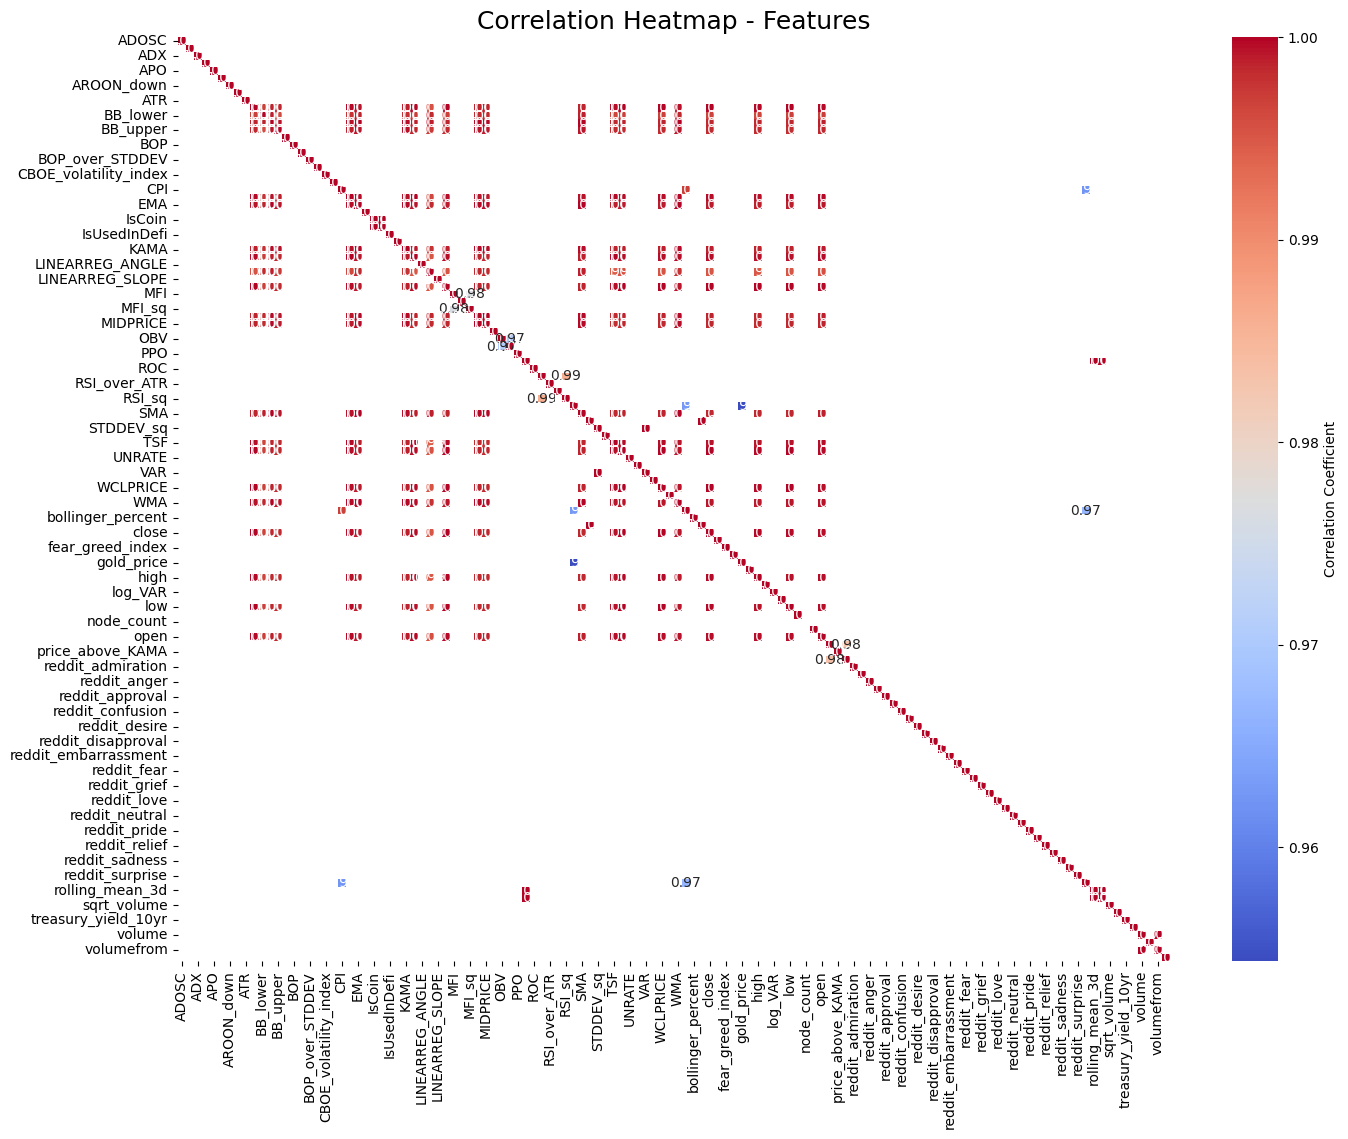

Dropping 33 highly correlated features: ['BB_lower', 'BB_middle', 'BB_upper', 'DEMA', 'EMA', 'IsToken', 'KAMA', 'LINEARREG', 'LINEARREG_INTERCEPT', 'MEDPRICE', 'MFI_sq', 'MIDPOINT', 'MIDPRICE', 'OBV_sq', 'RSI_sq', 'SMA', 'TSF', 'TYPPRICE', 'VAR', 'WCLPRICE', 'WMA', 'block_number', 'bollinger_spread', 'close', 'gold_price', 'high', 'low', 'open', 'price_above_SMA', 'retail_sales', 'rolling_mean_3d', 'rolling_std_3d', 'volumefrom']


In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select numeric features (excluding target + IDs)
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns.difference(
    ['time', 'symbol', 'date', 'returns']
)

# 2. Calculate correlation matrix
corr_matrix = merged_df[numeric_cols].corr().abs()

# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            mask=corr_matrix < 0.95, cbar_kws={'label': 'Correlation Coefficient'})

# Title and display the plot
plt.title('Correlation Heatmap - Features', fontsize=18)
plt.show()

# 3. Identify columns to drop: if correlation > threshold (e.g. 0.95)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

correlation_threshold = 0.95
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]

print(f"Dropping {len(to_drop)} highly correlated features: {to_drop}")

# 4. Drop them from merged_df
merged_df_clean_collinear = merged_df.drop(columns=to_drop)


In [113]:
merged_df_clean_collinear

time symbol       date    volumeto  IsUsedInDefi  IsUsedInNft  \
0       1655078400  1INCH 2022-06-13  1118042.36           1.0          0.0   
1       1655164800  1INCH 2022-06-14  1786752.28           1.0          0.0   
2       1655251200  1INCH 2022-06-15   861098.03           1.0          0.0   
3       1655337600  1INCH 2022-06-16  1080786.65           1.0          0.0   
4       1655424000  1INCH 2022-06-17   534918.27           1.0          0.0   
...            ...    ...        ...         ...           ...          ...   
199995  1741046400    ZRX 2025-03-04   835970.68           1.0          0.0   
199996  1741132800    ZRX 2025-03-05   806258.33           1.0          0.0   
199997  1741219200    ZRX 2025-03-06   288552.85           1.0          0.0   
199998  1741305600    ZRX 2025-03-07   386032.69           1.0          0.0   
199999  1741392000    ZRX 2025-03-08   331720.17           1.0          0.0   

        IsCoin  Sentiment       volume        ADX        RSI        MFI  \
0          0.0       1.00  1388791.600  21.721593  27.101412  10.972752   
1          0.0       1.00  2385533.225  24.308300  24.256902   8.865663   
2          0.0       1.00  1166923.575  26.810735  23.913175   5.620748   
3          0.0       1.00  1489928.920  28.291811  29.939284   8.452163   
4          0.0       1.00   706795.560  29.576120  26.586585  11.759234   
...        ...        ...          ...        ...        ...        ...   
199995     0.0       0.78  1870941.090  28.953387  36.397041  30.837840   
199996     0.0       0.78  1928853.125  29.245292  37.035288  29.612893   
199997     0.0       0.78   663709.565  29.078509  40.742748  33.800819   
199998     0.0       0.78   883521.390  28.574345  38.480146  29.427110   
199999     0.0       0.78   771884.205  28.440692  38.695813  31.385385   

             APO  AROON_down   AROON_up    AROONOSC       BOP     MOM  \
0      -0.064110  100.000000  14.285714  -85.714286 -0.620491 -0.2662   
1      -0.081706  100.000000   7.142857  -92.857143 -0.548626 -0.4059   
2      -0.096864  100.000000   0.000000 -100.000000 -0.125475 -0.3750   
3      -0.105921  100.000000   0.000000 -100.000000  0.382716 -0.3209   
4      -0.115475   92.857143   0.000000  -92.857143 -0.806452 -0.3557   
...          ...         ...        ...         ...       ...     ...   
199995 -0.006910  100.000000   0.000000 -100.000000 -0.888462 -0.0605   
199996 -0.010877  100.000000  21.428571  -78.571429  0.068841 -0.0395   
199997 -0.012792   92.857143  14.285714  -78.571429  0.666667 -0.0308   
199998 -0.015513   85.714286   7.142857  -78.571429 -0.476636 -0.0552   
199999 -0.018239   78.571429   0.000000  -78.571429  0.025000 -0.0377   

              PPO        ROC      WILLR         ADOSC           OBV       ATR  \
0       -7.201968 -29.023114 -99.312242 -2.699559e+06 -3.201916e+07  0.057275   
1       -9.300803 -40.388060 -92.371365 -2.799676e+06 -3.440469e+07  0.059941   
2      -11.191942 -38.759690 -90.775159 -2.382823e+06 -3.557161e+07  0.059416   
3      -12.395557 -33.757627 -77.617675 -1.560621e+06 -3.408168e+07  0.062115   
4      -13.753573 -38.230868 -90.302107 -1.267711e+06 -3.478848e+07  0.062550   
...           ...        ...        ...           ...           ...       ...   
199995  -2.229281 -18.233876 -94.281915  3.933155e+05  4.941839e+08  0.029604   
199996  -3.516888 -12.631916 -74.273412  6.310579e+05  4.961128e+08  0.029461   
199997  -4.141708  -9.777778 -62.432723  8.693288e+05  4.967765e+08  0.028535   
199998  -5.047345 -16.767922 -73.412271  7.222538e+05  4.958930e+08  0.028025   
199999  -5.960866 -12.071726 -70.165094  6.516872e+05  4.966649e+08  0.027738   

        AVGPRICE      BETA    CORREL  LINEARREG_ANGLE  LINEARREG_SLOPE  \
0       0.677825  0.524121  0.966477        -1.331780        -0.023248   
1       0.618675  1.054279  0.979265        -1.445964        -0.025242   
2       0.586950  0.601176  0.981800        -1.539564        -0.026877   
3       0.598100  

In [114]:
merged_df_clean_collinear.columns

Index(['time', 'symbol', 'date', 'volumeto', 'IsUsedInDefi', 'IsUsedInNft',
       'IsCoin', 'Sentiment', 'volume', 'ADX', 'RSI', 'MFI', 'APO',
       'AROON_down', 'AROON_up', 'AROONOSC', 'BOP', 'MOM', 'PPO', 'ROC',
       'WILLR', 'ADOSC', 'OBV', 'ATR', 'AVGPRICE', 'BETA', 'CORREL',
       'LINEARREG_ANGLE', 'LINEARREG_SLOPE', 'STDDEV', 'returns',
       'lagged_return_1d', 'momentum_ratio_3d', 'log_volume', 'sqrt_volume',
       'vol_chg_3d', 'RSI_sentiment', 'MFI_sentiment', 'BOP_ATR', 'ADX_OBV',
       'PPO_STD', 'price_above_EMA', 'price_above_KAMA', 'bollinger_percent',
       'BOP_sq', 'ADOSC_sq', 'log_VAR', 'VAR_sq', 'STDDEV_sq', 'RSI_over_ATR',
       'BOP_over_STDDEV', 'volume_over_ATR', 'USD_strength_index',
       'CBOE_volatility_index', 'treasury_yield_10yr',
       'consumer_sentiment_index', 'CPI', 'FEDFUNDS', 'UNRATE',
       'grocery_prices_index', 'fear_greed_index', 'sentiment', 'oil_price',
       'S&P 500 Price', 'gas_price_gwei', 'node_count', 'reddit_sentiment'

In [115]:
final_50_features = ['symbol', 'date',
    'RSI', 'MFI', 'APO', 'AROON_up', 'AROON_down', 'AROONOSC', 'ADX', 'MOM', 'ROC', 'WILLR',
    'BOP', 'OBV', 'ADOSC', 'ATR', 'CORREL', 'LINEARREG_ANGLE', 'STDDEV', 

    'AVGPRICE', 'price_above_EMA', 'price_above_KAMA',

    'volume', 'vol_chg_3d', 'volume_over_ATR', 'lagged_return_1d',

    'Sentiment', 'RSI_sentiment', 'MFI_sentiment', 'reddit_sentiment', 'fear_greed_index', 'title_sentiment',

    'momentum_ratio_3d', 'BOP_ATR', 'ADX_OBV', 'PPO_STD',
    'BOP_sq', 'VAR_sq', 'STDDEV_sq',
    'RSI_over_ATR', 'BOP_over_STDDEV', 'bollinger_percent','BOP_sq', 'log_VAR',

    'USD_strength_index', 'CBOE_volatility_index',
    'gas_price_gwei', 'treasury_yield_10yr',
    'consumer_sentiment_index', 'CPI', 'FEDFUNDS', 'UNRATE', 'returns'
]


In [116]:
len(final_50_features)


53

In [117]:
merged_df_clean_collinear_sample = merged_df_clean_collinear[final_50_features]

In [118]:
merged_df_clean_collinear_sample

symbol       date        RSI        MFI       APO   AROON_up  \
0       1INCH 2022-06-13  27.101412  10.972752 -0.064110  14.285714   
1       1INCH 2022-06-14  24.256902   8.865663 -0.081706   7.142857   
2       1INCH 2022-06-15  23.913175   5.620748 -0.096864   0.000000   
3       1INCH 2022-06-16  29.939284   8.452163 -0.105921   0.000000   
4       1INCH 2022-06-17  26.586585  11.759234 -0.115475   0.000000   
...       ...        ...        ...        ...       ...        ...   
199995    ZRX 2025-03-04  36.397041  30.837840 -0.006910   0.000000   
199996    ZRX 2025-03-05  37.035288  29.612893 -0.010877  21.428571   
199997    ZRX 2025-03-06  40.742748  33.800819 -0.012792  14.285714   
199998    ZRX 2025-03-07  38.480146  29.427110 -0.015513   7.142857   
199999    ZRX 2025-03-08  38.695813  31.385385 -0.018239   0.000000   

        AROON_down    AROONOSC        ADX     MOM        ROC      WILLR  \
0       100.000000  -85.714286  21.721593 -0.2662 -29.023114 -99.312242   
1       100.000000  -92.857143  24.308300 -0.4059 -40.388060 -92.371365   
2       100.000000 -100.000000  26.810735 -0.3750 -38.759690 -90.775159   
3       100.000000 -100.000000  28.291811 -0.3209 -33.757627 -77.617675   
4        92.857143  -92.857143  29.576120 -0.3557 -38.230868 -90.302107   
...            ...         ...        ...     ...        ...        ...   
199995  100.000000 -100.000000  28.953387 -0.0605 -18.233876 -94.281915   
199996  100.000000  -78.571429  29.245292 -0.0395 -12.631916 -74.273412   
199997   92.857143  -78.571429  29.078509 -0.0308  -9.777778 -62.432723   
199998   85.714286  -78.571429  28.574345 -0.0552 -16.767922 -73.412271   
199999   78.571429  -78.571429  28.440692 -0.0377 -12.071726 -70.165094   

             BOP           OBV         ADOSC       ATR    CORREL  \
0      -0.620491 -3.201916e+07 -2.699559e+06  0.057275  0.966477   
1      -0.548626 -3.440469e+07 -2.799676e+06  0.059941  0.979265   
2      -0.125475 -3.557161e+07 -2.382823e+06  0.059416  0.981800   
3       0.382716 -3.408168e+07 -1.560621e+06  0.062115  0.986554   
4      -0.806452 -3.478848e+07 -1.267711e+06  0.062550  0.987228   
...          ...           ...           ...       ...       ...   
199995 -0.888462  4.941839e+08  3.933155e+05  0.029604  0.744872   
199996  0.068841  4.961128e+08  6.310579e+05  0.029461  0.825088   
199997  0.666667  4.967765e+08  8.693288e+05  0.028535  0.844388   
199998 -0.476636  4.958930e+08  7.222538e+05  0.028025  0.837095   
199999  0.025000  4.966649e+08  6.516872e+05  0.027738  0.821692   

        LINEARREG_ANGLE    STDDEV  AVGPRICE  price_above_EMA  \
0             -1.331780  0.097006  0.677825        -0.163731   
1             -1.445964  0.106250  0.618675        -0.186880   
2             -1.539564  0.112748  0.586950        -0.167683   
3             -1.509829  0.111019  0.598100        -0.113085   
4             -1.527433  0.112157  0.602500        -0.145674   
...                 ...       ...       ...              ...   
199995        -0.151777  0.016355  0.293700        -0.032021   
199996        -0.187904  0.018037  0.267675        -0.026105   
199997        -0.191732  0.018169  0.277575        -0.013091   
199998        -0.177679  0.017282  0.279700        -0.020185   
199999        -0.180664  0.017413  0.273100        -0.016974   

        price_above_KAMA       volume  vol_chg_3d  volume_over_ATR  \
0              -0.170123  1388791.600   -0.202376     2.424793e+07   
1              -0.135660  2385533.225    0.149990     3.979820e+07   
2              -0.087502  1166923.575   -0.135214     1.963976e+07   
3              -0.036827  1489928.920    0.072824     2.398653e+07   
4              -0.066147   706795.560   -0.703716     1.129972e+07   
...                  ...          ...         ...              ...   
199995         -0.049507  1870941.090    0.349515     6.319961e+07   
199996         -0.045713  1928853.125    2.028231     6.547238e+07   
199997         -0.033771   663709.565

In [126]:
merged_df_clean_collinear_sample.isnull().sum()
# Show rows with any NaN or Inf in numeric columns
problem_rows = merged_df_clean_collinear_sample[numeric_cols][inf_mask | merged_df_clean_collinear_sample[numeric_cols].isna()].dropna(how='all')
merged_df_clean_collinear_sample[merged_df_clean_collinear_sample.index.isin(problem_rows.index)]
import numpy as np

# Replace inf and -inf with 0 for volume because the calculations result in inf when volume change is 0
for col in numeric_cols: # Volume change is the only column with inf values
    merged_df_clean_collinear_sample[col] = merged_df_clean_collinear_sample[col].replace([np.inf, -np.inf], 0)


C:\Users\Justin\AppData\Local\Temp\ipykernel_16196\3454480499.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean_collinear_sample[col] = merged_df_clean_collinear_sample[col].replace([np.inf, -np.inf], 0)


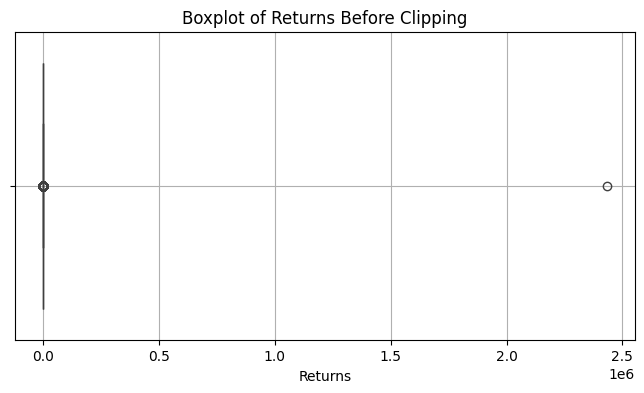

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: if you have many symbols, pick one or a few
sampled = merged_df_clean_collinear_sample

plt.figure(figsize=(8, 4))
sns.boxplot(x=sampled['returns'], whis=1.5)
plt.title("Boxplot of Returns Before Clipping")
plt.xlabel("Returns")
plt.grid(True)
plt.show()


In [132]:
merged_df_clean_collinear_sample_clipped = merged_df_clean_collinear_sample.copy()

# Get 1st and 99th percentile thresholds
low, high = merged_df_clean_collinear_sample_clipped['returns'].quantile([0.01, 0.99])

# Clip returns to those thresholds
merged_df_clean_collinear_sample_clipped['returns'] = merged_df_clean_collinear_sample['returns'].clip(lower=low, upper=high)


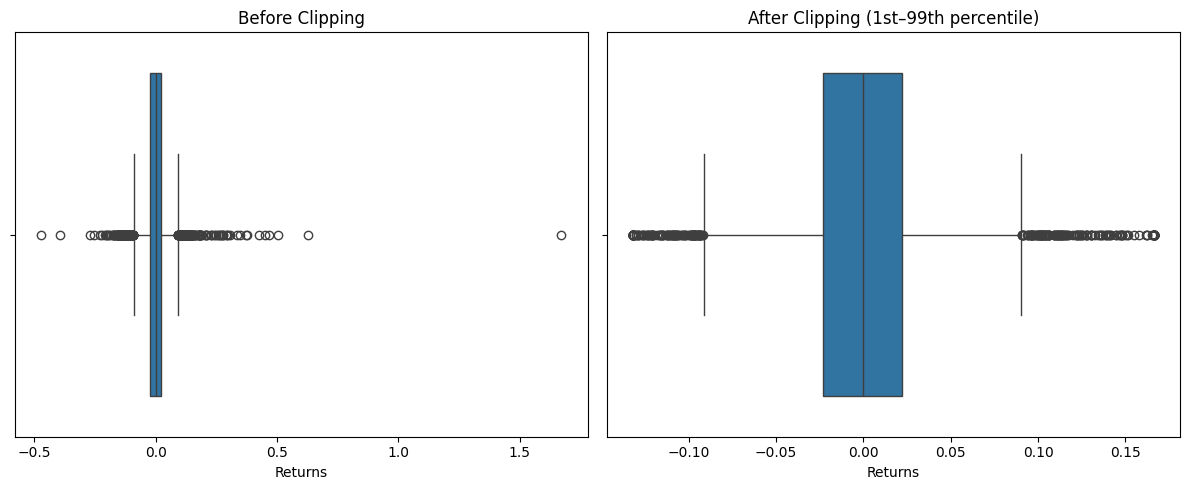

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample from both DataFrames to make plots faster (optional)
sample_size = 5000
original_sample = merged_df_clean_collinear_sample['returns'].sample(sample_size, random_state=42)
clipped_sample = merged_df_clean_collinear_sample_clipped['returns'].sample(sample_size, random_state=42)

# Plot side-by-side boxplots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=original_sample, whis=1.5)
plt.title("Before Clipping")
plt.xlabel("Returns")

plt.subplot(1, 2, 2)
sns.boxplot(x=clipped_sample, whis=1.5)
plt.title("After Clipping (1st–99th percentile)")
plt.xlabel("Returns")

plt.tight_layout()
plt.show()


In [134]:
# merged_df_clean_collinear_sample_clipped_pre_norm_path = os.path.join(data_path, "pre_norm_df.csv")
# merged_df_clean_collinear_sample_clipped.to_csv(merged_df_clean_collinear_sample_clipped_pre_norm_path)

### Scaling

In [136]:
from sklearn.preprocessing import StandardScaler

# Selecting numerical columns (excluding time/symbol/date/returns)
numeric_cols = merged_df_clean_collinear_sample_clipped.select_dtypes(include=['float64', 'int64']).columns.difference(['symbol', 'date', 'returns'])

# Define a function to apply standard scaling per symbol
def scale_group(group):
    scaler = StandardScaler()
    group[numeric_cols] = scaler.fit_transform(group[numeric_cols])
    return group

# Apply scaling per symbol
merged_df_scaled = merged_df_clean_collinear_sample_clipped.groupby("symbol", group_keys=False).apply(scale_group)


C:\Users\Justin\AppData\Local\Temp\ipykernel_16196\1518974873.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df_scaled = merged_df_clean_collinear_sample_clipped.groupby("symbol", group_keys=False).apply(scale_group)


In [137]:
# Display scaled data
merged_df_scaled

symbol       date       RSI       MFI       APO  AROON_up  AROON_down  \
0       1INCH 2022-06-13 -1.723868 -2.256947 -1.914760 -0.886598    1.434670   
1       1INCH 2022-06-14 -1.960420 -2.371935 -2.481271 -1.080179    1.434670   
2       1INCH 2022-06-15 -1.989005 -2.549018 -2.969314 -1.273759    1.434670   
3       1INCH 2022-06-16 -1.487868 -2.394501 -3.260897 -1.273759    1.434670   
4       1INCH 2022-06-17 -1.766681 -2.214026 -3.568516 -1.273759    1.234017   
...       ...        ...       ...       ...       ...       ...         ...   
199995    ZRX 2025-03-04 -1.048499 -1.378551 -0.125076 -1.243975    1.487110   
199996    ZRX 2025-03-05 -0.993739 -1.450573 -0.204849 -0.647630    1.487110   
199997    ZRX 2025-03-06 -0.675648 -1.204339 -0.243357 -0.846412    1.285714   
199998    ZRX 2025-03-07 -0.869774 -1.461496 -0.298082 -1.045193    1.084318   
199999    ZRX 2025-03-08 -0.851270 -1.346357 -0.352910 -1.243975    0.882921   

        AROONOSC       ADX       MOM       ROC     WILLR       BOP       OBV  \
0      -1.356681 -0.516907 -3.497959 -1.809914 -1.638675 -1.251464 -2.061000   
1      -1.472340 -0.268233 -5.396014 -2.531929 -1.387937 -1.108274 -2.096685   
2      -1.587999 -0.027660 -4.976187 -2.428479 -1.330274 -0.265155 -2.114141   
3      -1.587999  0.114724 -4.241149 -2.110698 -0.854961  0.747408 -2.091853   
4      -1.472340  0.238192 -4.713964 -2.394883 -1.313185 -1.621988 -2.102426   
...          ...       ...       ...       ...       ...       ...       ...   
199995 -1.633851  0.147396 -0.506131 -0.748345 -1.482240 -1.752343  1.817431   
199996 -1.274552  0.173890 -0.326085 -0.543340 -0.712152  0.130497  1.829944   
199997 -1.274552  0.158752 -0.251494 -0.438892 -0.256428  1.306313  1.834250   
199998 -1.274552  0.112993 -0.460691 -0.694698 -0.679008 -0.942356  1.828518   
199999 -1.274552  0.100862 -0.310652 -0.522840 -0.554031  0.044271  1.833525   

           ADOSC       ATR    CORREL  LINEARREG_ANGLE    STDDEV  AVGPRICE  \
0      -0.968560  1.673372  0.840478        -3.939988  4.319909  1.775851   
1      -1.004547  1.850976  0.905911        -4.287120  4.879889  1.353955   
2      -0.854710  1.816047  0.918883        -4.571670  5.273524  1.127672   
3      -0.559170  1.995832  0.943206        -4.481273  5.168791  1.207201   
4      -0.453884  2.024786  0.946654        -4.534793  5.237704  1.238584   
...          ...       ...       ...              ...       ...       ...   
199995  0.158025 -0.015825 -0.383598        -0.273321 -0.283994 -0.240206   
199996  0.236940 -0.021627  0.098718        -0.341257 -0.240395 -0.406163   
199997  0.316032 -0.059153  0.214764        -0.348455 -0.236973 -0.343032   
199998  0.267212 -0.079811  0.170910        -0.322029 -0.259966 -0.329482   
199999  0.243788 -0.091465  0.078298        -0.327641 -0.256558 -0.371569   

        price_above_EMA  price_above_KAMA    volume  vol_chg_3d  \
0             -4.733818         -3.869099 -0.062290   -0.273518   
1             -5.419384         -3.053672  0.231535   -0.144298   
2             -4.850853         -1.914221 -0.127693   -0.248888   
3             -3.233938         -0.715216 -0.032476   -0.172596   
4             -4.199054         -1.408952 -0.263332   -0.457370   
...                 ...               ...       ...         ...   
199995        -0.588118         -0.718955 -0.233354   -0.068360   
199996        -0.477245         -0.649271 -0.220590    0.757132   
199997        -0.233351         -0.429890 -0.499415   -0.515230   
199998        -0.366309         -0.567522 -0.450971   -0.499754   
199999        -0.306125         -0.525915 -0.475574   -0.535187   

        volume_over_ATR  lagged_return_1d  Sentiment  RSI_sentiment  \
0             -0.352050         -1.875157        0.0      -1.723868   
1             -0.129719         -1.388898        0.0      -1.960420   
2             -0.417936         -1.788303        0.0      -1.989005   
3             -0.355788         -0.243486        0.0      -1.487868   


In [138]:
merged_df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 199999
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   symbol                    200000 non-null  object        
 1   date                      200000 non-null  datetime64[ns]
 2   RSI                       200000 non-null  float64       
 3   MFI                       200000 non-null  float64       
 4   APO                       200000 non-null  float64       
 5   AROON_up                  200000 non-null  float64       
 6   AROON_down                200000 non-null  float64       
 7   AROONOSC                  200000 non-null  float64       
 8   ADX                       200000 non-null  float64       
 9   MOM                       200000 non-null  float64       
 10  ROC                       200000 non-null  float64       
 11  WILLR                     200000 non-null  float64       
 12  BOP    

Series is binary categorical
Column 'IsUsedInDefi' is stationary or no differencing necessary.
Series is binary categorical
Column 'IsUsedInNft' is stationary or no differencing necessary.
Series is binary categorical
Column 'IsToken' is stationary or no differencing necessary.
Series is binary categorical
Column 'IsCoin' is stationary or no differencing necessary.
Column 'Sentiment' is non-stationary (ADF p > 0.05). Applying first-order differencing.
Column 'ADX' is stationary or no differencing necessary.
Column 'RSI' is stationary or no differencing necessary.
Column 'MFI' is stationary or no differencing necessary.
Column 'APO' is stationary or no differencing necessary.
Column 'BOP' is stationary or no differencing necessary.
Column 'MOM' is stationary or no differencing necessary.
Column 'PPO' is stationary or no differencing necessary.
Column 'ROC' is stationary or no differencing necessary.
Column 'WILLR' is stationary or no differencing necessary.
Column 'ADOSC' is stationary 

In [139]:
# merged_df_clean_collinear_sample_clipped_post_norm_path = os.path.join(data_path, "post_norm_df.csv")
# merged_df_scaled.to_csv(merged_df_clean_collinear_sample_clipped_post_norm_path)

### Import and split

In [11]:
df_after_differencing_path = os.path.join(data_path, 'post_norm_df.csv')
merged_df_stationary = pd.read_csv(df_after_differencing_path, index_col=0).reset_index(drop=True)

In [12]:
merged_df_stationary

symbol        date       RSI       MFI       APO  AROON_up  AROON_down  \
0       1INCH  2022-06-13 -1.723868 -2.256947 -1.914760 -0.886598    1.434670   
1       1INCH  2022-06-14 -1.960420 -2.371935 -2.481271 -1.080179    1.434670   
2       1INCH  2022-06-15 -1.989005 -2.549018 -2.969314 -1.273759    1.434670   
3       1INCH  2022-06-16 -1.487868 -2.394501 -3.260897 -1.273759    1.434670   
4       1INCH  2022-06-17 -1.766681 -2.214026 -3.568516 -1.273759    1.234017   
...       ...         ...       ...       ...       ...       ...         ...   
199995    ZRX  2025-03-04 -1.048499 -1.378551 -0.125076 -1.243975    1.487110   
199996    ZRX  2025-03-05 -0.993739 -1.450573 -0.204849 -0.647630    1.487110   
199997    ZRX  2025-03-06 -0.675648 -1.204339 -0.243357 -0.846412    1.285714   
199998    ZRX  2025-03-07 -0.869774 -1.461496 -0.298082 -1.045193    1.084318   
199999    ZRX  2025-03-08 -0.851270 -1.346357 -0.352910 -1.243975    0.882921   

        AROONOSC       ADX       MOM       ROC     WILLR       BOP       OBV  \
0      -1.356681 -0.516907 -3.497959 -1.809914 -1.638675 -1.251464 -2.061000   
1      -1.472340 -0.268233 -5.396014 -2.531929 -1.387937 -1.108274 -2.096685   
2      -1.587999 -0.027660 -4.976187 -2.428479 -1.330274 -0.265155 -2.114141   
3      -1.587999  0.114724 -4.241149 -2.110698 -0.854961  0.747408 -2.091853   
4      -1.472340  0.238192 -4.713964 -2.394883 -1.313185 -1.621988 -2.102426   
...          ...       ...       ...       ...       ...       ...       ...   
199995 -1.633851  0.147396 -0.506131 -0.748345 -1.482240 -1.752343  1.817431   
199996 -1.274552  0.173890 -0.326085 -0.543340 -0.712152  0.130497  1.829944   
199997 -1.274552  0.158752 -0.251494 -0.438892 -0.256428  1.306313  1.834250   
199998 -1.274552  0.112993 -0.460691 -0.694698 -0.679008 -0.942356  1.828518   
199999 -1.274552  0.100862 -0.310652 -0.522840 -0.554031  0.044271  1.833525   

           ADOSC       ATR    CORREL  LINEARREG_ANGLE    STDDEV  AVGPRICE  \
0      -0.968560  1.673372  0.840478        -3.939988  4.319909  1.775851   
1      -1.004547  1.850976  0.905911        -4.287120  4.879889  1.353955   
2      -0.854710  1.816047  0.918883        -4.571670  5.273524  1.127672   
3      -0.559170  1.995832  0.943206        -4.481273  5.168791  1.207201   
4      -0.453884  2.024786  0.946654        -4.534793  5.237704  1.238584   
...          ...       ...       ...              ...       ...       ...   
199995  0.158025 -0.015825 -0.383598        -0.273321 -0.283994 -0.240206   
199996  0.236940 -0.021627  0.098718        -0.341257 -0.240395 -0.406163   
199997  0.316032 -0.059153  0.214764        -0.348455 -0.236973 -0.343032   
199998  0.267212 -0.079811  0.170910        -0.322029 -0.259966 -0.329482   
199999  0.243788 -0.091465  0.078298        -0.327641 -0.256558 -0.371569   

        price_above_EMA  price_above_KAMA    volume  vol_chg_3d  \
0             -4.733818         -3.869099 -0.062290   -0.273518   
1             -5.419384         -3.053672  0.231535   -0.144298   
2             -4.850853         -1.914221 -0.127693   -0.248888   
3             -3.233938         -0.715216 -0.032476   -0.172596   
4             -4.199054         -1.408952 -0.263332   -0.457370   
...                 ...               ...       ...         ...   
199995        -0.588118         -0.718955 -0.233354   -0.068360   
199996        -0.477245         -0.649271 -0.220590    0.757132   
199997        -0.233351         -0.429890 -0.499415   -0.515230   
199998        -0.366309         -0.567522 -0.450971   -0.499754   
199999        -0.306125         -0.525915 -0.475574   -0.535187   

        volume_over_ATR  lagged_return_1d  Sentiment  RSI_sentiment  \
0             -0.352050         -1.875157        0.0      -1.723868   
1             -0.129719         -1.388898        0.0      -1.960420   
2             -0.417936         -1.788303        0.0      -1.989005   
3             -0.355788         -0.243486        0.0      -

In [13]:
# Define features and target variable
feature_cols = merged_df_stationary.columns.difference(['date', 'returns', 'symbol'])
target_col = 'returns'  # Target variable

# Initialize storage dictionary
data_store = {'big_xtrain': [], 'big_ytrain': [], 'big_xtest': [], 'big_ytest': [], 'big_xoos': [], 'big_yoos': []}

# Function to split data
def split_data(group):
    group = group.sort_values(by='date')  # Ensure sorting by time
    n = len(group)

    # Define split indices
    train_end = n // 3
    test_end = 2 * (n // 3)

    # Splitting into train, test, and OOS
    xtrain, ytrain = group.iloc[:train_end][feature_cols], group.iloc[:train_end][target_col]
    xtest, ytest = group.iloc[train_end:test_end][feature_cols], group.iloc[train_end:test_end][target_col]
    xoos, yoos = group.iloc[test_end:][feature_cols], group.iloc[test_end:][target_col]

    return xtrain, ytrain, xtest, ytest, xoos, yoos

# Apply split per symbol and append to dictionary
for symbol, group in merged_df_stationary.groupby("symbol"):
    xtrain, ytrain, xtest, ytest, xoos, yoos = split_data(group)

    data_store['big_xtrain'].append(xtrain)
    data_store['big_ytrain'].append(ytrain)
    data_store['big_xtest'].append(xtest)
    data_store['big_ytest'].append(ytest)
    data_store['big_xoos'].append(xoos)
    data_store['big_yoos'].append(yoos)

# Convert lists to DataFrames
data_store = {key: pd.concat(value) for key, value in data_store.items()}

# Check data_store contents
for key, df in data_store.items():
    print(f"{key}: {df.shape}")

big_xtrain: (66600, 50)
big_ytrain: (66600,)
big_xtest: (66600, 50)
big_ytest: (66600,)
big_xoos: (66800, 50)
big_yoos: (66800,)


# EDA

In [48]:
df_after_differencing_path = os.path.join(data_path, 'post_norm_df.csv')
merged_df_stationary = pd.read_csv(df_after_differencing_path, index_col=0).reset_index(drop=True)
merged_df_stationary["date"] = pd.to_datetime(merged_df_stationary["date"])

In [16]:
merged_df_stationary.columns

Index(['symbol', 'date', 'RSI', 'MFI', 'APO', 'AROON_up', 'AROON_down',
       'AROONOSC', 'ADX', 'MOM', 'ROC', 'WILLR', 'BOP', 'OBV', 'ADOSC', 'ATR',
       'CORREL', 'LINEARREG_ANGLE', 'STDDEV', 'AVGPRICE', 'price_above_EMA',
       'price_above_KAMA', 'volume', 'vol_chg_3d', 'volume_over_ATR',
       'lagged_return_1d', 'Sentiment', 'RSI_sentiment', 'MFI_sentiment',
       'reddit_sentiment', 'fear_greed_index', 'title_sentiment',
       'momentum_ratio_3d', 'BOP_ATR', 'ADX_OBV', 'PPO_STD', 'BOP_sq',
       'VAR_sq', 'STDDEV_sq', 'RSI_over_ATR', 'BOP_over_STDDEV',
       'bollinger_percent', 'BOP_sq.1', 'log_VAR', 'USD_strength_index',
       'CBOE_volatility_index', 'gas_price_gwei', 'treasury_yield_10yr',
       'consumer_sentiment_index', 'CPI', 'FEDFUNDS', 'UNRATE', 'returns'],
      dtype='object')

## Outliers

In [49]:
import numpy as np

# Select only numeric columns
numeric_cols = merged_df_stationary.select_dtypes(include=[np.number])

# Z-score threshold
z_thresh = 3

# Identify outliers using absolute z-scores
outlier_mask = np.abs(numeric_cols) > z_thresh

# Option 1: Clip the outliers
scaled_df_clipped = numeric_cols.clip(lower=-z_thresh, upper=z_thresh)

# Optionally, add non-numeric columns back in (e.g., date, symbol)
non_numeric_cols = merged_df_stationary.drop(columns=numeric_cols.columns)
scaled_df_clipped_full = pd.concat([scaled_df_clipped, non_numeric_cols], axis=1)


In [ ]:
# scaled_df_clipped_full_path = os.path.join(data_path, 'post_norm_clipped.csv')
# scaled_df_clipped_full.to_csv(scaled_df_clipped_full_path)

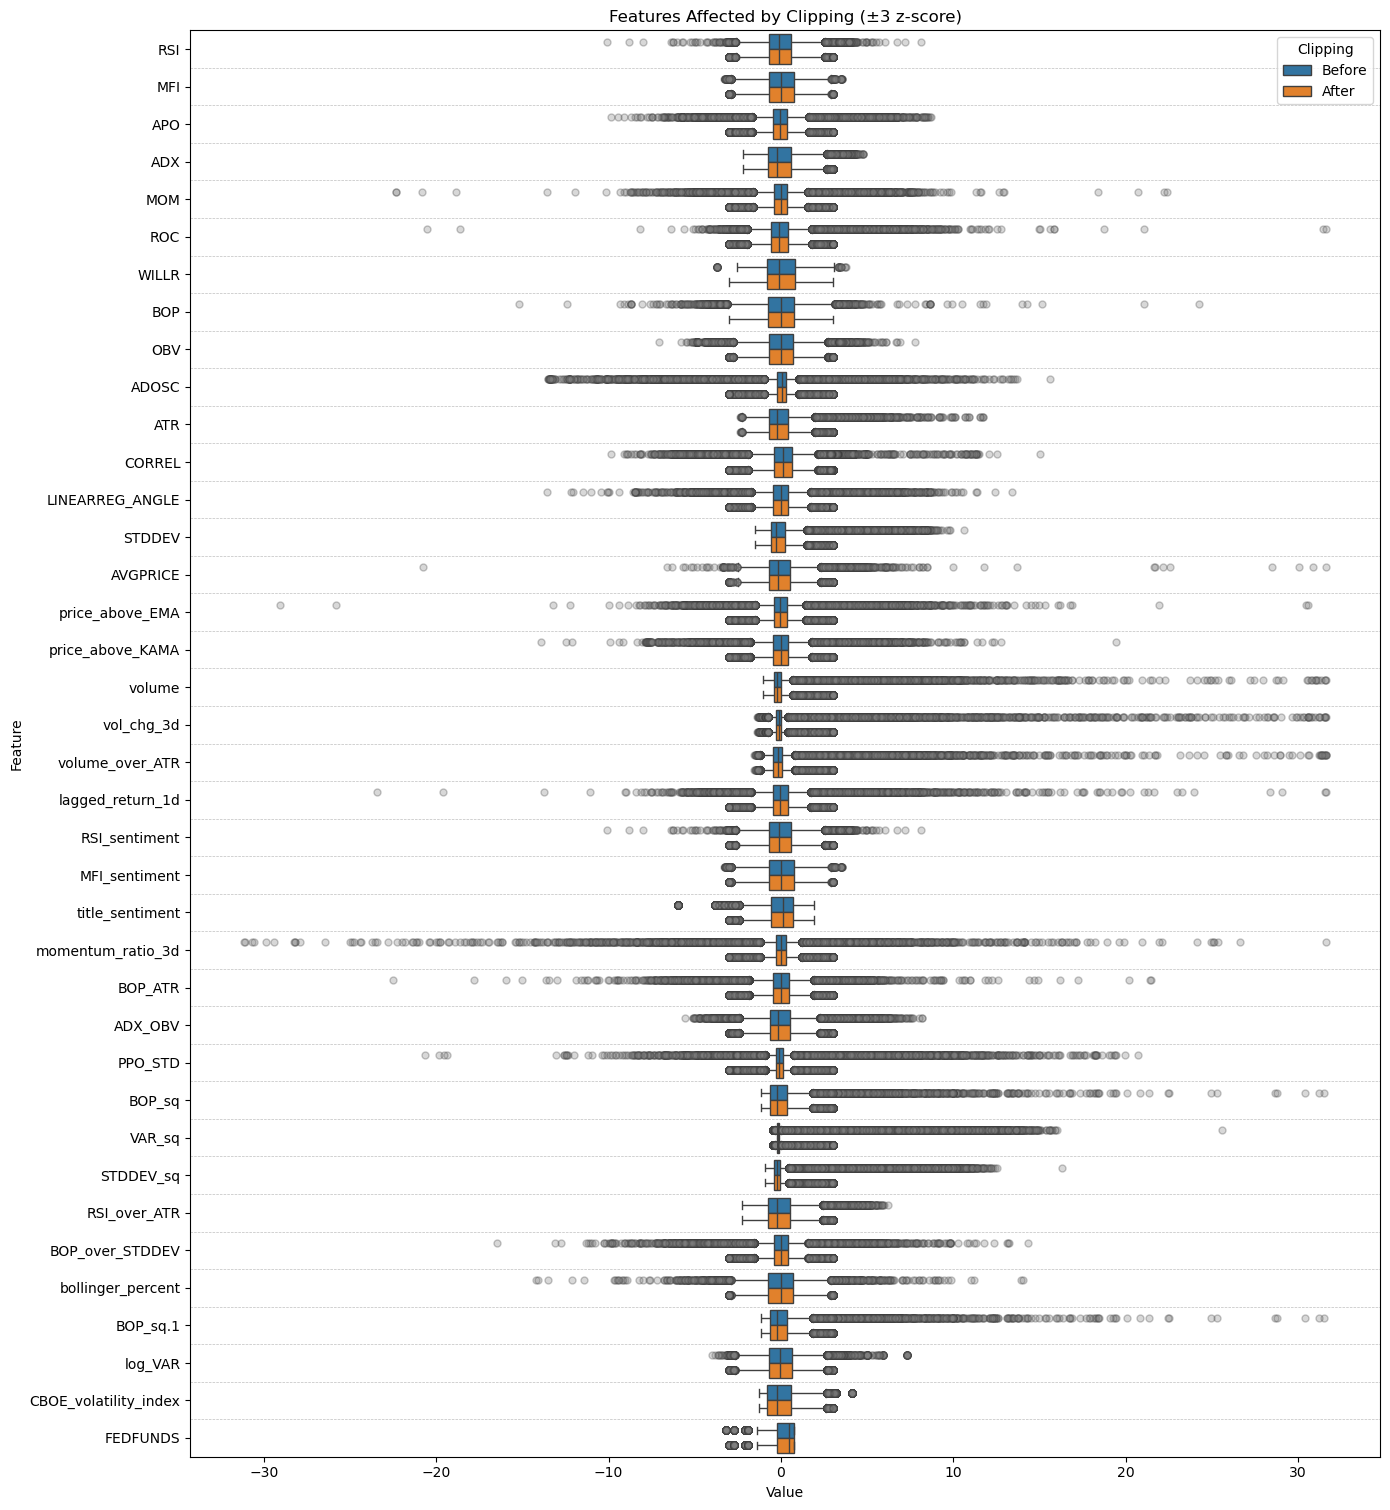

In [34]:
plt.figure(figsize=(14, max(6, len(clipped_cols) * 0.4)))

# Boxplot with vertical orientation (features on y-axis)
ax = sns.boxplot(data=df_long_clipped, y='Feature', x='Value', hue='Clipping', fliersize=5, orient='h')

plt.yticks(rotation=0)

# Add horizontal dashed lines between features
num_features = len(clipped_cols)
for i in range(1, num_features):
    plt.axhline(y=i - 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Make outlier (flier) points more transparent
for line in ax.lines:
    if line.get_linestyle() == 'None':  # outlier markers have no connecting line
        line.set_alpha(0.3)
        line.set_markerfacecolor('gray')  # optional: subtle color

# Tidy up
plt.title('Features Affected by Clipping (±3 z-score)')
plt.tight_layout()
plt.show()


## Correlation exploration

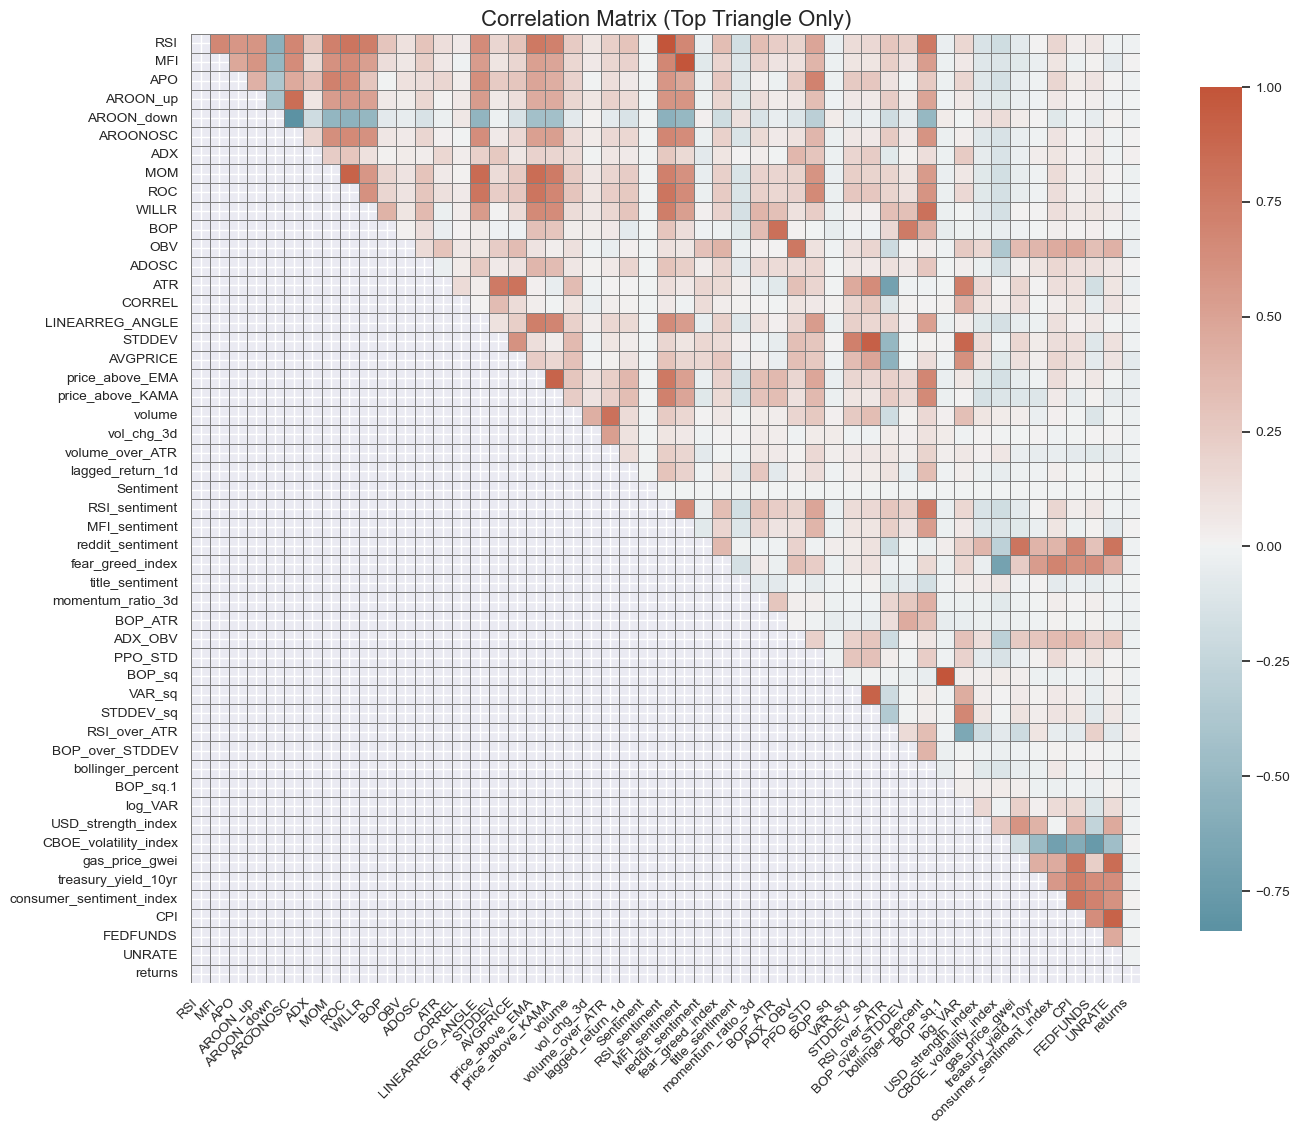

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select only numeric columns
numeric_df = merged_df_stationary.select_dtypes(include=[np.number])

# 2. Compute correlation matrix
corr = numeric_df.corr()

# 3. Mask the bottom triangle
mask = np.tril(np.ones_like(corr, dtype=bool))

# 4. Plot heatmap without annotations
plt.figure(figsize=(14, 12))
sns.set(font_scale=0.9)

# Use a diverging color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

ax = sns.heatmap(
    corr, 
    mask=mask, 
    cmap=cmap, 
    annot=False,
    linewidths=0.5, 
    linecolor='gray',
    cbar_kws={"shrink": 0.8},
    square=True,
    center=0
)

plt.title("Correlation Matrix (Top Triangle Only)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


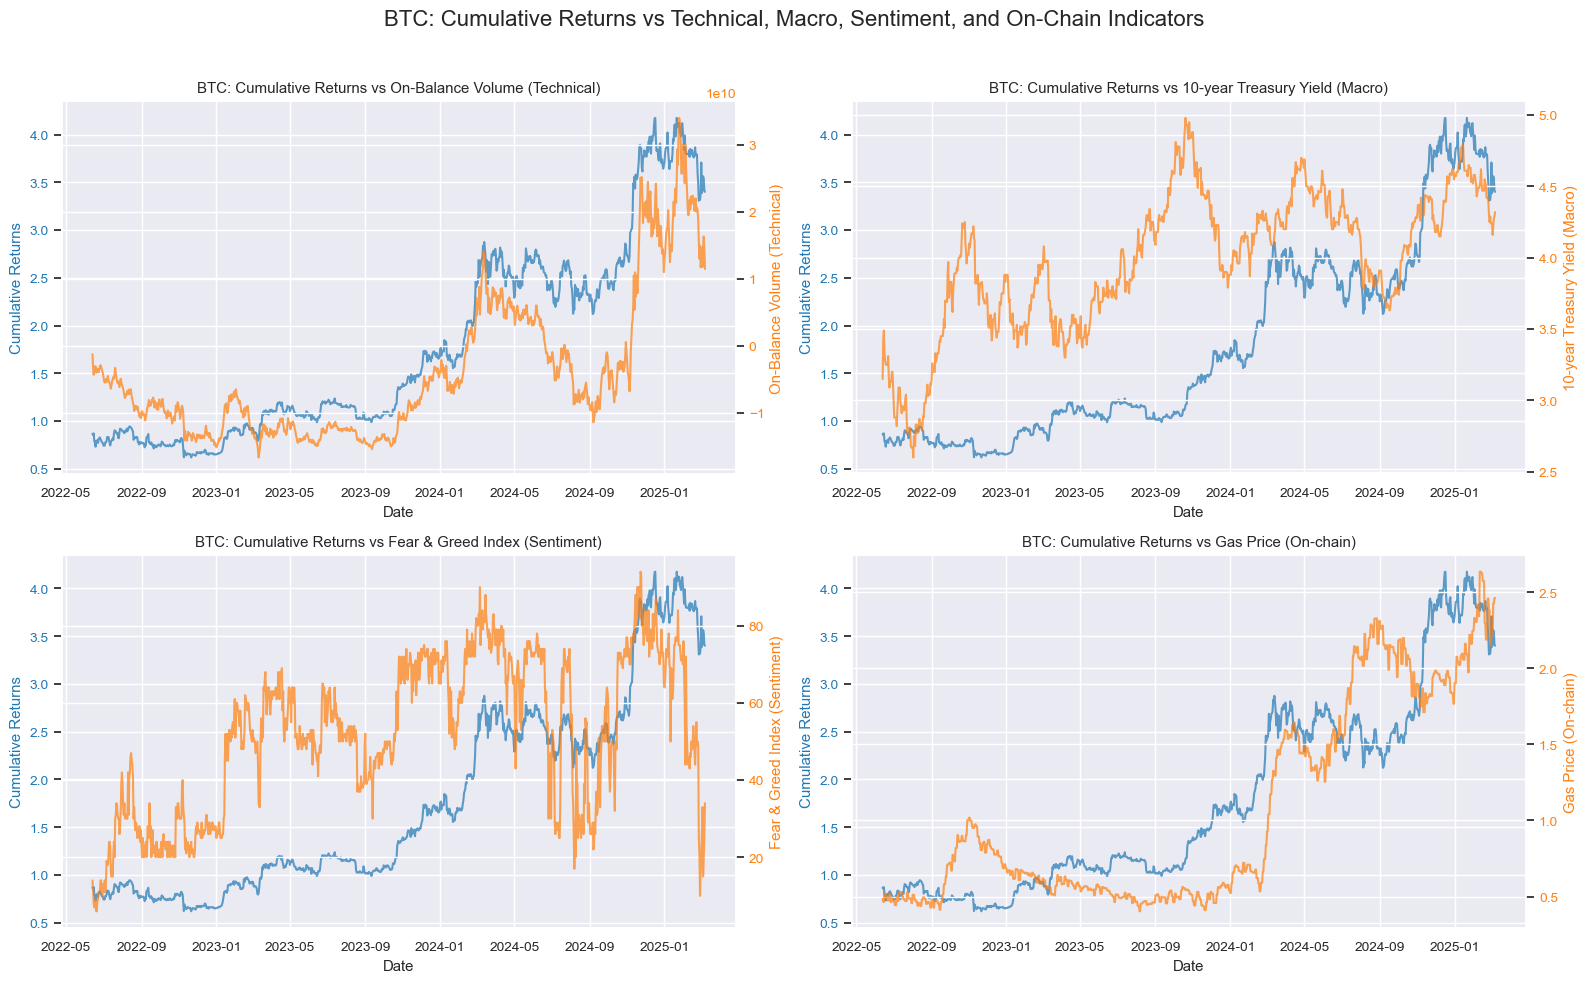

In [44]:
df_after_differencing_path = os.path.join(data_path, 'pre_norm_df.csv')
merged_df_stationary = pd.read_csv(df_after_differencing_path, index_col=0).reset_index(drop=True)
merged_df_stationary["date"] = pd.to_datetime(merged_df_stationary["date"])

import matplotlib.pyplot as plt
import seaborn as sns

# Filter BTC data
btc_df = merged_df_stationary[merged_df_stationary['symbol'] == 'BTC'].copy()
btc_df['date'] = pd.to_datetime(btc_df['date'])
btc_df = btc_df.sort_values('date')

# Compute cumulative returns
btc_df['cumulative_returns'] = (1 + btc_df['returns']).cumprod()

# Select features
features = ['OBV', 'treasury_yield_10yr', 'fear_greed_index', 'gas_price_gwei']
labels = {
    'OBV': 'On-Balance Volume (Technical)',
    'treasury_yield_10yr': '10-year Treasury Yield (Macro)',
    'fear_greed_index': 'Fear & Greed Index (Sentiment)',
    'gas_price_gwei': 'Gas Price (On-chain)'
}

# Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    # Plot cumulative returns (left y-axis)
    ax1.plot(btc_df['date'], btc_df['cumulative_returns'], color='tab:blue', label='Cumulative Returns', alpha=0.7)
    ax1.set_ylabel('Cumulative Returns', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot feature (right y-axis)
    ax2.plot(btc_df['date'], btc_df[feature], color='tab:orange', label=labels[feature], alpha=0.7)
    ax2.set_ylabel(labels[feature], color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    ax1.set_title(f"BTC: Cumulative Returns vs {labels[feature]}")
    ax1.set_xlabel('Date')

fig.suptitle("BTC: Cumulative Returns vs Technical, Macro, Sentiment, and On-Chain Indicators", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Streamlit Process 

In [7]:
crypto_data_path = os.path.join(data_path, 'post_norm_df.csv')
crypto_data = pd.read_csv(crypto_data_path, index_col=0).reset_index(drop=True)

In [9]:
crypto_data.rename(columns={'date': 'timestamp', 'returns':'target'}, inplace=True)

In [10]:
crypto_data

symbol   timestamp       RSI       MFI       APO  AROON_up  AROON_down  \
0       1INCH  2022-06-13 -1.723868 -2.256947 -1.914760 -0.886598    1.434670   
1       1INCH  2022-06-14 -1.960420 -2.371935 -2.481271 -1.080179    1.434670   
2       1INCH  2022-06-15 -1.989005 -2.549018 -2.969314 -1.273759    1.434670   
3       1INCH  2022-06-16 -1.487868 -2.394501 -3.260897 -1.273759    1.434670   
4       1INCH  2022-06-17 -1.766681 -2.214026 -3.568516 -1.273759    1.234017   
...       ...         ...       ...       ...       ...       ...         ...   
199995    ZRX  2025-03-04 -1.048499 -1.378551 -0.125076 -1.243975    1.487110   
199996    ZRX  2025-03-05 -0.993739 -1.450573 -0.204849 -0.647630    1.487110   
199997    ZRX  2025-03-06 -0.675648 -1.204339 -0.243357 -0.846412    1.285714   
199998    ZRX  2025-03-07 -0.869774 -1.461496 -0.298082 -1.045193    1.084318   
199999    ZRX  2025-03-08 -0.851270 -1.346357 -0.352910 -1.243975    0.882921   

        AROONOSC       ADX       MOM       ROC     WILLR       BOP       OBV  \
0      -1.356681 -0.516907 -3.497959 -1.809914 -1.638675 -1.251464 -2.061000   
1      -1.472340 -0.268233 -5.396014 -2.531929 -1.387937 -1.108274 -2.096685   
2      -1.587999 -0.027660 -4.976187 -2.428479 -1.330274 -0.265155 -2.114141   
3      -1.587999  0.114724 -4.241149 -2.110698 -0.854961  0.747408 -2.091853   
4      -1.472340  0.238192 -4.713964 -2.394883 -1.313185 -1.621988 -2.102426   
...          ...       ...       ...       ...       ...       ...       ...   
199995 -1.633851  0.147396 -0.506131 -0.748345 -1.482240 -1.752343  1.817431   
199996 -1.274552  0.173890 -0.326085 -0.543340 -0.712152  0.130497  1.829944   
199997 -1.274552  0.158752 -0.251494 -0.438892 -0.256428  1.306313  1.834250   
199998 -1.274552  0.112993 -0.460691 -0.694698 -0.679008 -0.942356  1.828518   
199999 -1.274552  0.100862 -0.310652 -0.522840 -0.554031  0.044271  1.833525   

           ADOSC       ATR    CORREL  LINEARREG_ANGLE    STDDEV  AVGPRICE  \
0      -0.968560  1.673372  0.840478        -3.939988  4.319909  1.775851   
1      -1.004547  1.850976  0.905911        -4.287120  4.879889  1.353955   
2      -0.854710  1.816047  0.918883        -4.571670  5.273524  1.127672   
3      -0.559170  1.995832  0.943206        -4.481273  5.168791  1.207201   
4      -0.453884  2.024786  0.946654        -4.534793  5.237704  1.238584   
...          ...       ...       ...              ...       ...       ...   
199995  0.158025 -0.015825 -0.383598        -0.273321 -0.283994 -0.240206   
199996  0.236940 -0.021627  0.098718        -0.341257 -0.240395 -0.406163   
199997  0.316032 -0.059153  0.214764        -0.348455 -0.236973 -0.343032   
199998  0.267212 -0.079811  0.170910        -0.322029 -0.259966 -0.329482   
199999  0.243788 -0.091465  0.078298        -0.327641 -0.256558 -0.371569   

        price_above_EMA  price_above_KAMA    volume  vol_chg_3d  \
0             -4.733818         -3.869099 -0.062290   -0.273518   
1             -5.419384         -3.053672  0.231535   -0.144298   
2             -4.850853         -1.914221 -0.127693   -0.248888   
3             -3.233938         -0.715216 -0.032476   -0.172596   
4             -4.199054         -1.408952 -0.263332   -0.457370   
...                 ...               ...       ...         ...   
199995        -0.588118         -0.718955 -0.233354   -0.068360   
199996        -0.477245         -0.649271 -0.220590    0.757132   
199997        -0.233351         -0.429890 -0.499415   -0.515230   
199998        -0.366309         -0.567522 -0.450971   -0.499754   
199999        -0.306125         -0.525915 -0.475574   -0.535187   

        volume_over_ATR  lagged_return_1d  Sentiment  RSI_sentiment  \
0             -0.352050         -1.875157        0.0      -1.723868   
1             -0.129719         -1.388898        0.0      -1.960420   
2             -0.417936         -1.788303        0.0      -1.989005   
3             -0.355788         -0.243486        0.0      -

In [12]:
crypto_data_path = os.path.join(data_path, "crypto_data.csv")
crypto_data.to_csv(crypto_data_path, index=False)

# Bayesian SARIMAX combination model

## Datset preparation

In [ ]:
import pandas as pd
from pathlib import Path

# ---- Config ----
INPUT_PATH = os.path.join(data_path, "crypto_data.csv")
OUTPUT_PATH = os.path.join(data_path, "processed_bambi_data.csv")

# Columns
TARGET_COL = "target"
EXOG_COLS = [col for col in df.columns if col not in ["timestamp", "symbol", "target"] and not col.startswith("lag")]
LAG_STEPS = [1, 3, 5]                   # Generate lag1, lag3
SYMBOLS_TO_KEEP = 3                  # Limit for faster training

# ---- Load data ----
df = pd.read_csv(INPUT_PATH, parse_dates=["timestamp"])
df = df.sort_values(["symbol", "timestamp"])

# ---- Keep only a few symbols (optional) ----
symbols = df["symbol"].unique()
df = df[df["symbol"].isin(symbols[:SYMBOLS_TO_KEEP])]

# ---- Generate lag features for the target ----
for lags in LAG_STEPS: # Already lagged once
    lag = lags - 1
    df[f"lag{lags}"] = df.groupby("symbol")[TARGET_COL].shift(lags)

# ---- Drop any rows with missing values from lagging ----
required_cols = [TARGET_COL] + EXOG_COLS + [f"lag{l}" for l in LAG_STEPS]
df_cleaned = df.dropna(subset=required_cols)

# ---- Save cleaned dataset ----
Path("sample_data").mkdir(exist_ok=True)
df_cleaned.to_csv(OUTPUT_PATH, index=False)

## Choosing Model Architecture

In [ ]:
import pandas as pd
import bambi as bmb
import arviz as az
from pathlib import Path

# ---- Config ----
DATA_PATH = os.path.join(data_path, "processed_bambi_data.csv")
TARGET_COL = "target"
EXOG_COLS = [col for col in df.columns if col not in ["timestamp", "symbol", "target"] and not col.startswith("lag")]
LAG_FEATURES = ["lag1", "lag3", "lag5"]         # Lags to compare
SYMBOLS_TO_USE = 3                      # Limit for manageable training
MODEL_SAVE_PATH = os.path.join(data_path, "best_bambi_model.nc.csv")

# ---- Load preprocessed dataset ----
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])

# Filter symbols for tractability
symbols = df["symbol"].unique()
df = df[df["symbol"].isin(symbols[:SYMBOLS_TO_USE])]

# Drop any remaining missing values from lag creation
df = df.dropna(subset=LAG_FEATURES + [TARGET_COL, EXOG_COLS])

# ---- Train models and compare with WAIC ----
models = {}
traces = {}

for lag_col in LAG_FEATURES:
    print(f"\n⏳ Training model with {lag_col}...")

    exog_formula = " + ".join(EXOG_COLS)    
    formula = f"{TARGET_COL} ~ 0 + {lag_col} + {exog_formula} + ({lag_col}|symbol)"
    
    model = bmb.Model(formula, data=df)
    trace = model.fit(draws=2000, tune=1000, target_accept=0.95, random_seed=42, idata_kwargs={"log_likelihood": True})
    
    models[lag_col] = model
    traces[lag_col] = trace

    pp_trace = model.predict(idata=trace, kind="pps", inplace=False)

# ---- Compare models using WAIC ----
print("\n📊 Comparing models using WAIC...")
comparison_df = az.compare(traces, ic="waic")
print(comparison_df)

# ---- Choose best model ----
best_lag = comparison_df.index[0]
print(f"\n✅ Best model uses: {best_lag}")

# ---- Save best model trace ----
Path("models").mkdir(exist_ok=True)
az.to_netcdf(traces[best_lag], "models/best_bambi_model_trace.nc")         # Only posterior
az.to_netcdf(pp_trace, "models/best_bambi_model_with_pp.nc")               # Posterior + predictions

print(f"✅ Saved best model's trace to: {MODEL_SAVE_PATH}")


# Modelling Prep

In [6]:
df_after_differencing_path = os.path.join(data_path, 'post_norm_df.csv')
merged_df_stationary = pd.read_csv(df_after_differencing_path, index_col=0).reset_index(drop=True)
merged_df_stationary["date"] = pd.to_datetime(merged_df_stationary["date"])

In [7]:
# Define features and target variable
feature_cols = merged_df_stationary.columns.difference(['date', 'returns', 'symbol'])
target_col = 'returns'  # Target variable

# Initialize storage dictionary
data_store = {'big_xtrain': [], 'big_ytrain': [], 'big_xtest': [], 'big_ytest': [], 'big_xoos': [], 'big_yoos': []}

# Function to split data
def split_data(group):
    group = group.sort_values(by='date')  # Ensure sorting by time
    n = len(group)

    # Define split indices
    train_end = n // 3
    test_end = 2 * (n // 3)

    # Splitting into train, test, and OOS
    xtrain, ytrain = group.iloc[:train_end][feature_cols], group.iloc[:train_end][target_col]
    xtest, ytest = group.iloc[train_end:test_end][feature_cols], group.iloc[train_end:test_end][target_col]
    xoos, yoos = group.iloc[test_end:][feature_cols], group.iloc[test_end:][target_col]

    return xtrain, ytrain, xtest, ytest, xoos, yoos

# Apply split per symbol and append to dictionary
for symbol, group in merged_df_stationary.groupby("symbol"):
    xtrain, ytrain, xtest, ytest, xoos, yoos = split_data(group)

    data_store['big_xtrain'].append(xtrain)
    data_store['big_ytrain'].append(ytrain)
    data_store['big_xtest'].append(xtest)
    data_store['big_ytest'].append(ytest)
    data_store['big_xoos'].append(xoos)
    data_store['big_yoos'].append(yoos)

# Convert lists to DataFrames
data_store = {key: pd.concat(value) for key, value in data_store.items()}

# Check data_store contents
for key, df in data_store.items():
    print(f"{key}: {df.shape}")

big_xtrain: (66600, 50)
big_ytrain: (66600,)
big_xtest: (66600, 50)
big_ytest: (66600,)
big_xoos: (66800, 50)
big_yoos: (66800,)


In [8]:
results_path = os.path.join(data_path,'results')
os.makedirs(results_path, exist_ok=True)